# Descriptive fit analysis

Last access (y.m.d): 21.05.18  
Last update (y.m.d): 21.05.18   

#### Plan: Update this to match descrAnalysis--V1-- and copy over relevant analyses from analysesLGN (and then deprecate)

In this notebook, I gather all LGN cells (data, model, descriptive fits) and analyze based on this complete set.

### Table of contents

- Initialize  
- Gather  
- Distribution of tuning measures  
  - model free measures  
  - comparison with derived measures  
  - comparison with Cavanuagh, other datasets  
- Simple vs complex  
- Tuning shifts  
  - Preferred spatial frequency with contrast 
  - Center of mass with contrast 
  - SFBW with contrast 
  - sfVariance with contrast 
  - Trajectories of these metrics across contrasts  
- Preferred spatial frequency with contrast *and* dispersion  
  - Histograms/trajectories of metrics with dispersion, split by contrast  
  - Median tuning measure shift across dispersion, plotted across all contrasts (together)  
     - sfCom and pSf  
     - sfCom and sfComCut (see figure for explanation)  
  - Contrast shifts across dispersion  
  - Plot shift distributions at each dispersion  

## Initialize

In [159]:
import pandas as pd
import pdb
import autoreload
import warnings
warnings.filterwarnings(action='once')

In [160]:
import numpy as np
import os
import helper_fcns as hf
import scipy.stats as ss
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
# plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

saveName = 'figures/reports/descrAnalysis_210429_LGNjoint/' # for one save name for all figures
save_loc = base_dir + saveName;

In [162]:
autoreload.reload(hf);

In [163]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.size'] = 20;
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';

## Gather data

Now, let's create a large list which will combine data/fits/analyses from all cells for all of the above experiments. For each cell, let's keep track of:
* "meta" parameters:
    * which experiment directory
    * which dataList, fitList, descrFit, rvcFit
    * which cell number within those lists
    * which experiment index?
    * which stimulus values (i.e. dispersions, sfs, contrasts)
* inferred parameters:
    * prefSf (for all conditions), along with % var explained
    * c50 (again, for all conditions)
* model parameters
    * fit parameters, loss value for weighted and flat

#### Create the jointList (will take <5 minutes when done in parallel) ... or load

Creation moved to jl_create.py -- see that script and run from there to create a jointList

So, just load the jointList you want

In [82]:
fitBase = '210304' # what's the fitbase for the descriptive fits?

suffix = 'LGN_2105_vT70_dvT70'
# suffix = 'LGN_210429_vT70_dvT60'
# suffix = 'V1_take2_210331_vT70_dvT60'
# suffix = 'V1_210331_vT70_dvT60'
# suffix = 'V1_200609_vT70_dvT60'
try:
    jointList = hf.np_smart_load(base_dir + 'jointList_%s.npy' % suffix)
    if jointList == []:
        jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
except: # if it wasn't pickled, then we'll need to just load without the .item which is implicit in hf.np_smart_load
    jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
#     jointList = np.load(base_dir + 'jointList_%s.npy' % suffix);

saveName = 'figures/reports/descrAnalysis_%s_LGN/' % suffix # for one save name for all figures
save_loc = base_dir + saveName;

## Distribution of tuning measures

Here, let's look at the distribution of preferred spatial frequencies and bandwidths in the population.

Suppose we are looking at the preferred spatial frequency measure. Located within metrics, the measure is organized by dispersion (low to high), and within that, by contrast (again, low to high). Thus, jointList[x]['metrics']['pSf'][0][6] would have the preferred spatial frequency zero dispersion, 6th highest (0-indexed) contrast. Thus, to get the highest contrast, we index "-1" for the contrast (single gratings, only, since with newer versions of the experiment, the total contrast values of different dispersions differ slightly, and therefore occupy different locations in the list of total contrasts).

#### Model-free measures

First, let's look at model-free measures of the spatial frequency tuning curve.

In [23]:
disp = 0;
con = -1; # highest for single gratings
comHighCon = np.array([jointList[i]['metrics']['sfCom'][disp][con] for i in range(len(jointList))])
comCutHighCon = np.array([jointList[i]['metrics']['sfComCut'][disp][con] for i in range(len(jointList))])
varHighCon = np.array([jointList[i]['metrics']['sfVar'][disp][con] for i in range(len(jointList))])

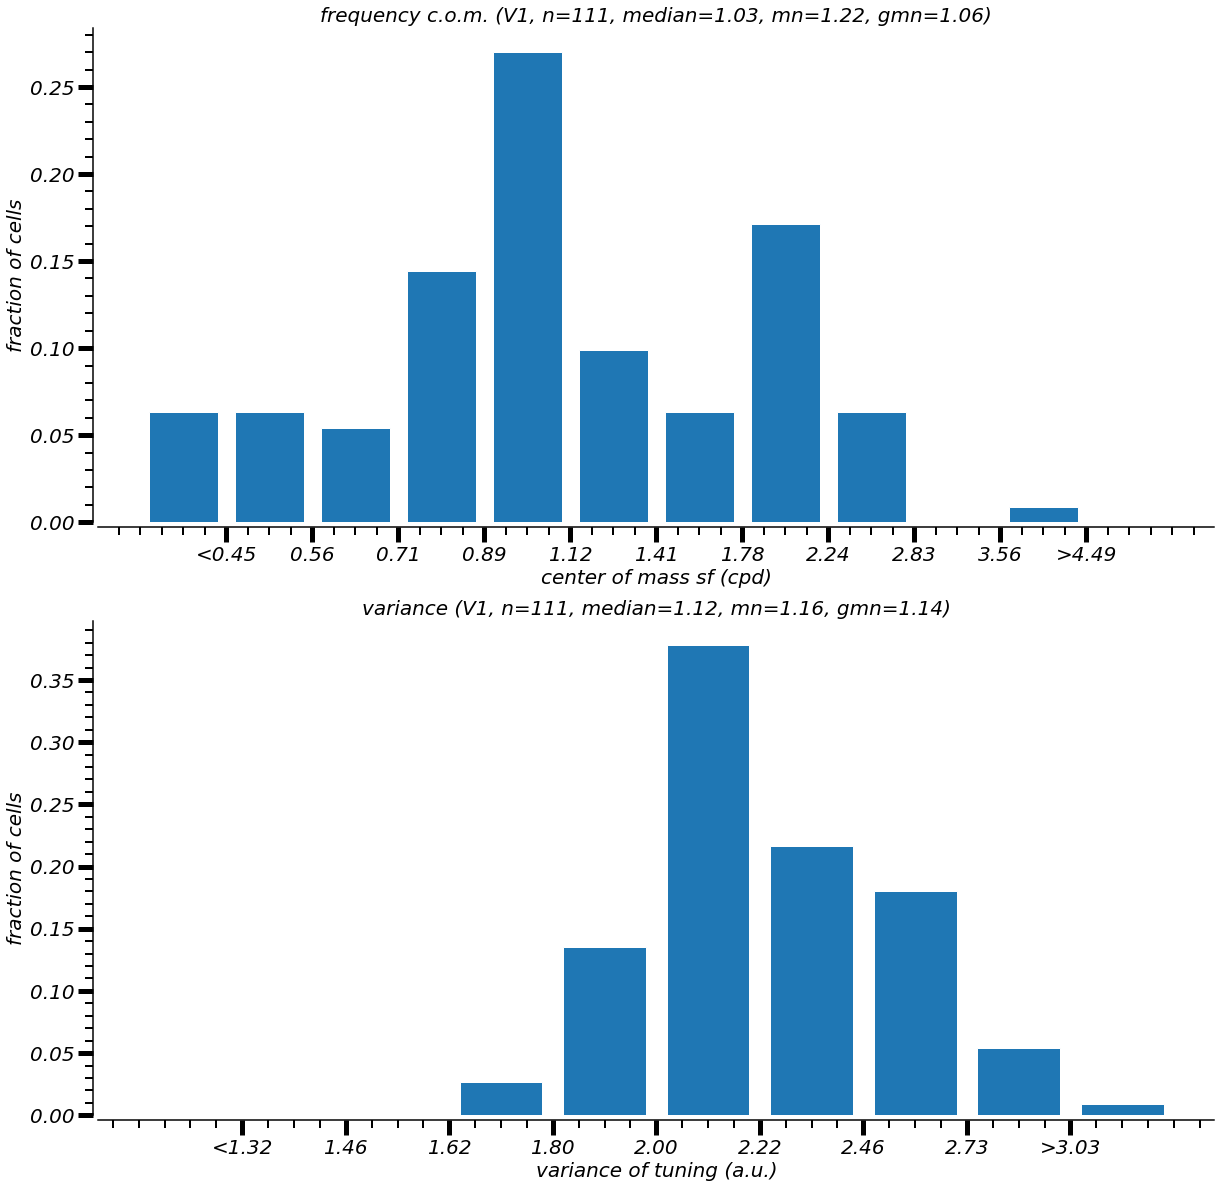

In [24]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

#######
# central tendency
#######
bins = np.linspace(-1.5, 2.5, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
coms_clipped = np.clip(hf.nan_rm(np.log2(comHighCon)), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSF = len(coms_clipped);
medianSF = np.nanmedian(comHighCon);
mnSF = np.nanmean(comHighCon);
gmnSF = gmean(hf.nan_rm(comHighCon));

# plot
vals, _ = np.histogram(coms_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[0].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
ax[0].set_xticks(tickVals);
ax[0].set_xticklabels(tickStrs, rotation=45);
sns.despine(ax=ax[0], offset=5)

ax[0].set_xlabel('center of mass sf (cpd)')
ax[0].set_ylabel('fraction of cells')
ax[0].set_title('frequency c.o.m. (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (nSF, medianSF, mnSF, gmnSF));


#######
# variance
#######
bins = np.linspace(0.25, 1.75, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
vars_clipped = np.clip(hf.nan_rm(varHighCon), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSF = len(vars_clipped);
medianSF = np.nanmedian(varHighCon);
mnSF = np.nanmean(varHighCon);
gmnSF = gmean(hf.nan_rm(varHighCon));

# plot
vals, _ = np.histogram(vars_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(ax=ax[1], offset=5)
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
ax[1].set_xticks(tickVals);
ax[1].set_xticklabels(tickStrs);

ax[1].set_xlabel('variance of tuning (a.u.)');
ax[1].set_ylabel('fraction of cells');
ax[1].set_title('variance (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (nSF, medianSF, mnSF, gmnSF));


Now, let's go to derived measures - i.e. measures of the tuning curve that rely on descriptive tuning functions

In [25]:
disp = 0;
con = -1; # highest for single gratings
pSfHighCon = np.array([jointList[i]['metrics']['pSf'][disp][con] for i in range(len(jointList))])
bwHalfHighCon = np.array([jointList[i]['metrics']['bwHalf'][disp][con] for i in range(len(jointList))])
bw34HighCon = np.array([jointList[i]['metrics']['bw34'][disp][con] for i in range(len(jointList))])

dog_pSfHighCon = np.array([jointList[i]['metrics']['dog_pSf'][disp][con] for i in range(len(jointList))])
dog_charFreqHighCon = np.array([jointList[i]['metrics']['dog_charFreq'][disp][con] for i in range(len(jointList))])

#### Compare model-free and derived measures

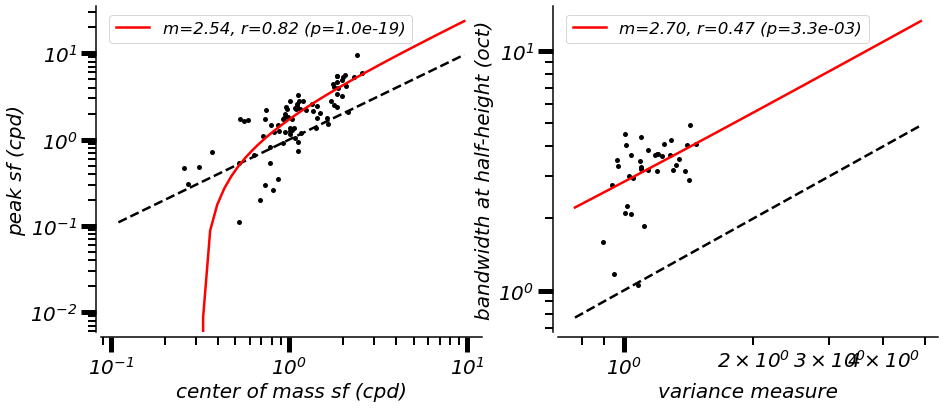

In [26]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

# central tendency
ax[0].loglog(comHighCon, pSfHighCon, 'o', c='k');
mn, mx = np.minimum(np.nanmin(comHighCon), np.nanmin(pSfHighCon)), np.maximum(np.nanmax(comHighCon), np.nanmax(pSfHighCon))
ax[0].loglog([mn, mx], [mn, mx], 'k--');
ax[0].set_xlabel('center of mass sf (cpd)')
ax[0].set_ylabel('peak sf (cpd)')
non_nan = np.logical_and(~np.isnan(comHighCon), ~np.isnan(pSfHighCon))
slope, intercept, r, p, err = linregress(comHighCon[non_nan], pSfHighCon[non_nan])
# slope, intercept, r, p, err = linregress(np.log(comHighCon[non_nan]), np.log(pSfHighCon[non_nan]))
plt_vals = np.geomspace(mn, mx, 50);
ax[0].loglog(plt_vals, intercept + plt_vals*slope, 'r-', label='m=%.2f, r=%.2f (p=%.1e)' % (slope, r, p))
ax[0].legend(fontsize='small');
sns.despine(ax=ax[0], offset=5)

# variance
ax[1].loglog(varHighCon, bwHalfHighCon, 'o', c='k');
mn, mx = np.minimum(np.nanmin(varHighCon), np.nanmin(bwHalfHighCon)), np.maximum(np.nanmax(varHighCon), np.nanmax(bwHalfHighCon))
ax[1].loglog([mn, mx], [mn, mx], 'k--');
ax[1].set_xlabel('variance measure')
ax[1].set_ylabel('bandwidth at half-height (oct)')
non_nan = np.logical_and(~np.isnan(varHighCon), ~np.isnan(bwHalfHighCon))
slope, intercept, r, p, err = linregress(varHighCon[non_nan], bwHalfHighCon[non_nan])
# slope, intercept, r, p, err = linregress(np.log(varHighCon[non_nan]), np.log(bwHalfHighCon[non_nan]))
plt_vals = np.geomspace(mn, mx, 50);
ax[1].loglog(plt_vals, intercept + plt_vals*slope, 'r-', label='m=%.2f, r=%.2f (p=%.1e)' % (slope, r, p))
ax[1].legend(fontsize='small');
sns.despine(ax=ax[1], offset=5)

In [27]:
bins = np.linspace(-2.5, 3.5, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [comHighCon, pSfHighCon];
fitStr = ['c.o.m.', 'pSf']

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

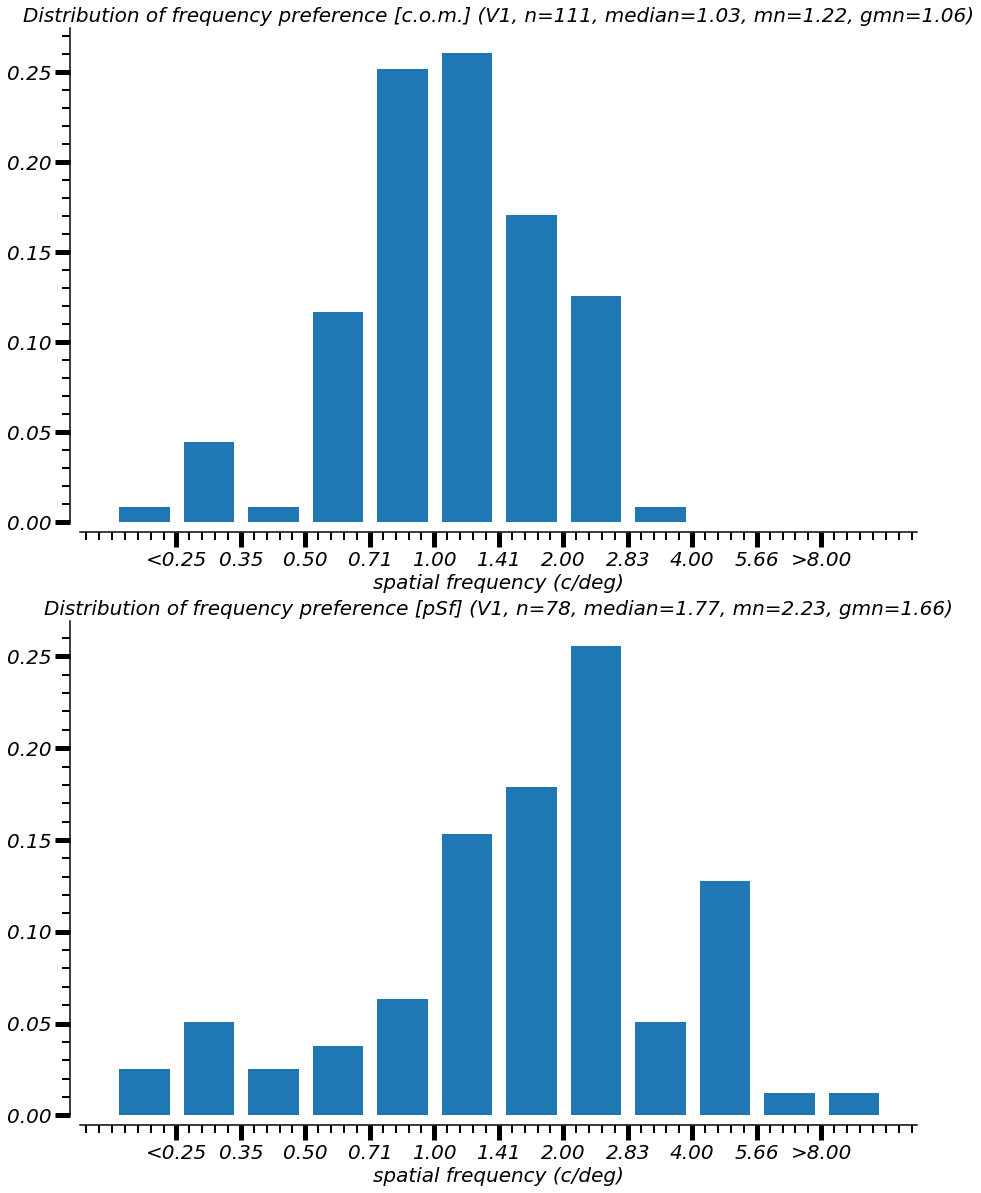

In [28]:
f, ax = plt.subplots(2, 1, figsize=(15, 2*10))
# ax.set(xscale="log")

for i in range(2):

    plt.subplot(2,1,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.xlabel('spatial frequency (c/deg)');
    plt.title('Distribution of frequency preference [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));


#### (return to my data) Plot the distribution of preferred frequency:

In [29]:
bins = np.linspace(-2.5, 3.5, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [pSfHighCon, dog_pSfHighCon];
fitStr = ['flex', 'DoG']

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


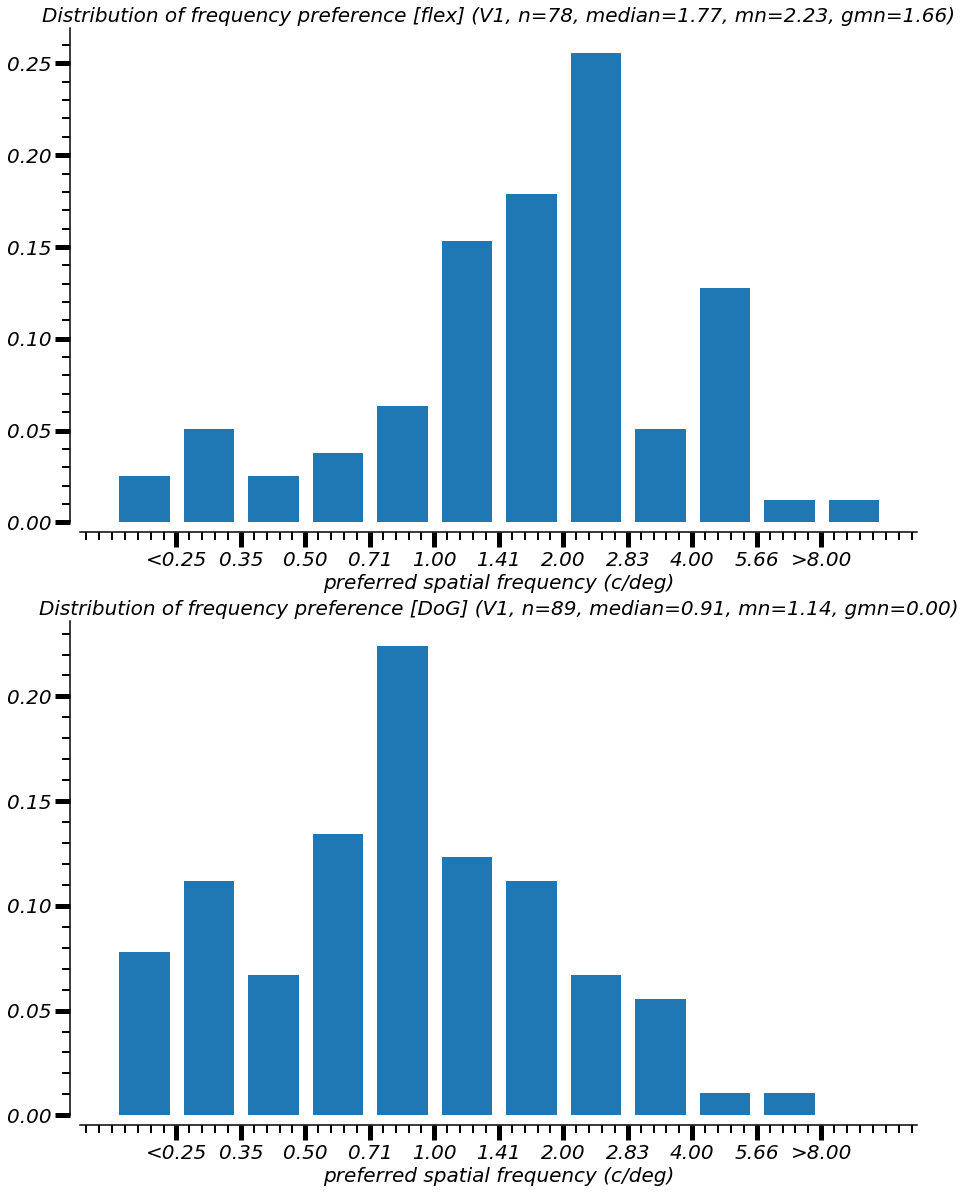

In [30]:
f, ax = plt.subplots(2, 1, figsize=(15, 2*10))
# ax.set(xscale="log")

for i in range(2):

    plt.subplot(2,1,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.xlabel('preferred spatial frequency (c/deg)');
    plt.title('Distribution of frequency preference [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));


##### Compare to existing measurements:

**DeValois, Albrecht, Thorell (1982):**

**Sach Sokol (intra-lab dataset):**


#### Plot the distribution of characteristic frequency:

In [17]:
bins = np.linspace(-0.5, 4.5, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

char_clipped = np.clip(hf.nan_rm(np.log2(dog_charFreqHighCon)), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nCF = len(char_clipped)
medianCF = np.nanmedian(dog_charFreqHighCon)
mnCF = np.nanmean(dog_charFreqHighCon);
gmnCF = gmean(hf.nan_rm(dog_charFreqHighCon));

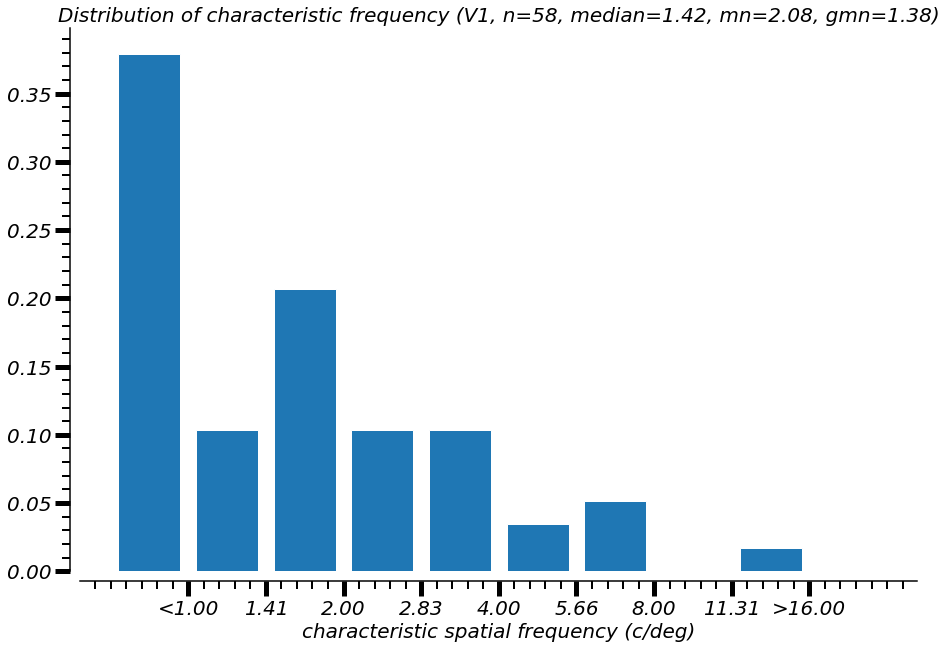

In [18]:
f, ax = plt.subplots(figsize=(15, 10))

vals, _ = np.histogram(char_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(offset=10)
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
plt.xticks(tickVals, tickStrs);

plt.xlabel('characteristic spatial frequency (c/deg)');
plt.title('Distribution of characteristic frequency (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (nCF, medianCF, mnCF, gmnCF));


#### Plot the distribution of frequency tuning bandwidth:

First, half-height

In [19]:
bins = np.linspace(0, 6, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
bwHalfClipped = np.clip(hf.nan_rm(bwHalfHighCon), clipLow, clipHigh)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# compute
nBW = len(bwHalfClipped);
medianBW = np.nanmedian(bwHalfHighCon);
mnBW = np.nanmean(bwHalfHighCon);

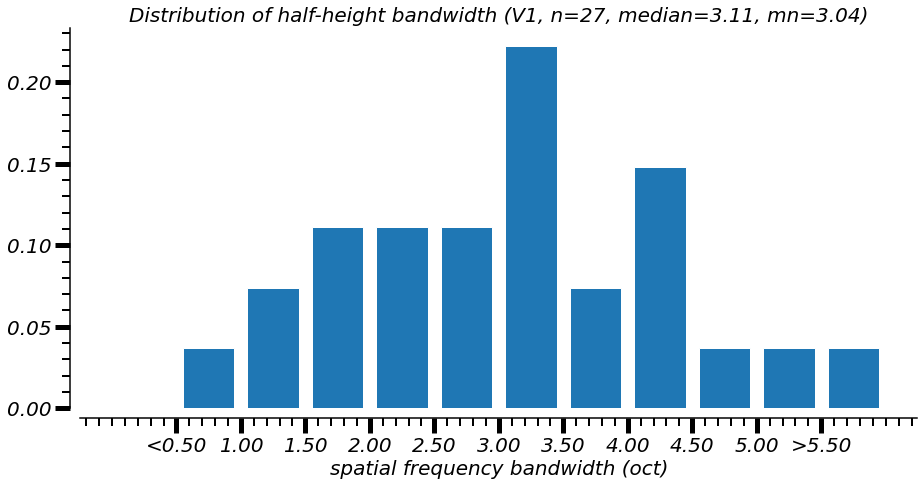

In [20]:
f, ax = plt.subplots(figsize=(15, 7))
# ax.set(xscale="log")

vals, _ = np.histogram(bwHalfClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(offset=10)
tickStrs = ['%.2f' % x for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
plt.xticks(tickVals, tickStrs);

plt.xlabel('spatial frequency bandwidth (oct)');
plt.title('Distribution of half-height bandwidth (V1, n=%d, median=%.2f, mn=%.2f)' % (nBW, medianBW, mnBW));

#### Compare to existing measurements:

**TBD (1982):**

**Sach Sokol (intra-lab dataset):**


Then, three-fourth height

In [21]:
bins = np.linspace(0, 6, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
bw34Clipped = np.clip(hf.nan_rm(bw34HighCon), clipLow, clipHigh)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# compute
nBW = len(bw34Clipped);
medianBW = np.nanmedian(bw34HighCon);
mnBW = np.nanmean(bw34HighCon);

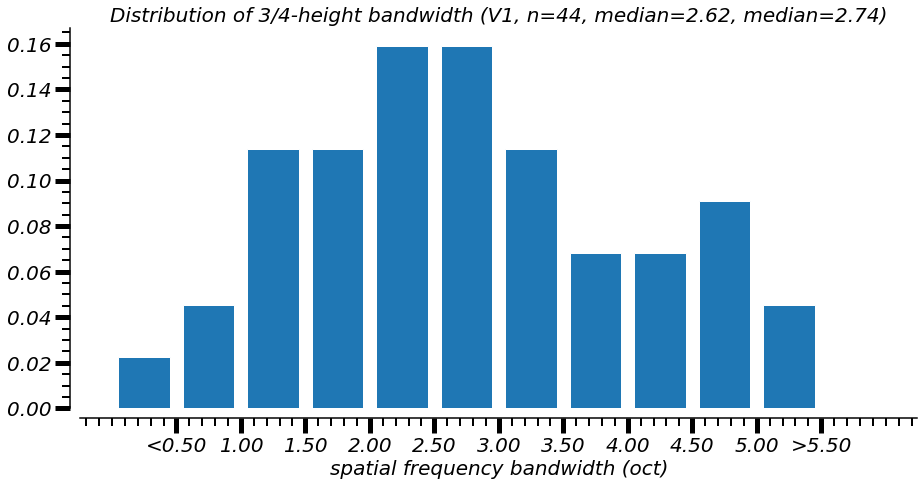

In [22]:
f, ax = plt.subplots(figsize=(15, 7))
vals, _ = np.histogram(bw34Clipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(offset=10)
tickStrs = ['%.2f' % x for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
plt.xticks(tickVals, tickStrs);

plt.xlabel('spatial frequency bandwidth (oct)');
plt.title('Distribution of 3/4-height bandwidth (V1, n=%d, median=%.2f, median=%.2f)' % (nBW, medianBW, mnBW));

### Relating fit quality to fit parameters

In [23]:
pSfHighCon = np.array([jointList[i]['metrics']['pSf'][disp][con] for i in range(len(jointList))])
bwHalfHighCon = np.array([jointList[i]['metrics']['bwHalf'][disp][con] for i in range(len(jointList))])
bw34HighCon = np.array([jointList[i]['metrics']['bw34'][disp][con] for i in range(len(jointList))])

In [24]:
dispInd, conInd = 0, -1;
# for high contrast, single gratings
descrVarExpl = [jointList[x]['metrics']['sfVarExpl'][dispInd][conInd] for x in range(len(jointList))]
dogVarExpl = [jointList[x]['metrics']['dog_varExpl'][dispInd][conInd] for x in range(len(jointList))]

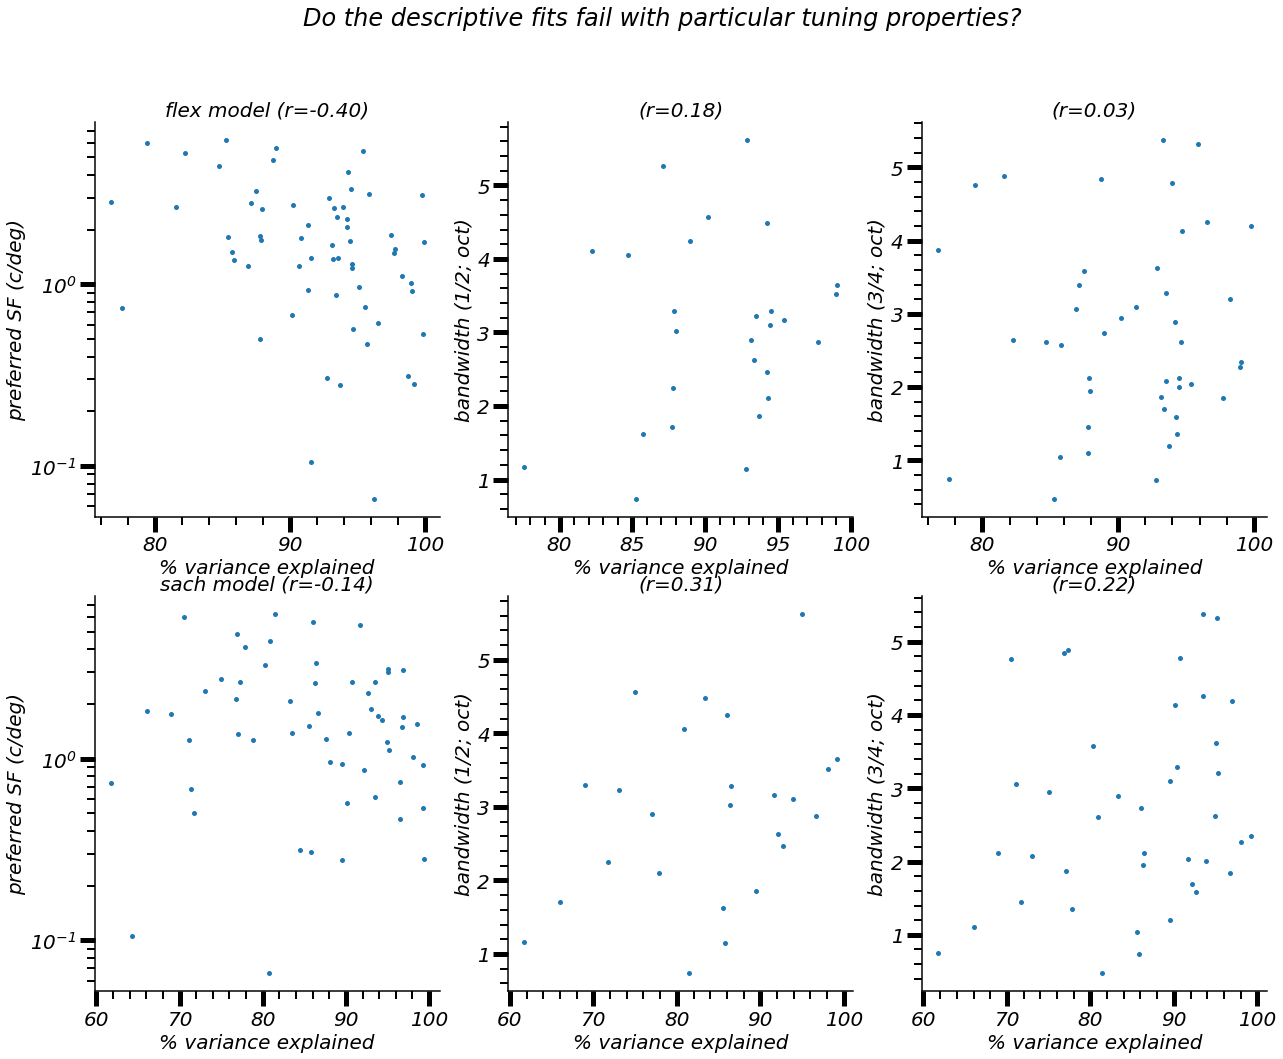

In [25]:
nMods, nComps = 2, 3;
f, ax = plt.subplots(nMods, nComps, figsize=(nComps*7, nMods*8))

allVar = [descrVarExpl, dogVarExpl];
modStr = [hf.descrMod_name(0), hf.descrMod_name(1)]; # 0 [flex], 1 [sach], 2[tony]

f.suptitle('Do the descriptive fits fail with particular tuning properties?')

for i in range(len(allVar)):

    ### compute the correlations
    jointNan = np.logical_or(np.isnan(allVar[i]), np.isnan(pSfHighCon));
    r = np.corrcoef(np.array(allVar[i])[~jointNan], pSfHighCon[~jointNan])
    rSf = r[0, 1]; # [0,1] and [1,0] are the same - corr. b/t "x" and "y"
    # bwHalf
    jointNan = np.logical_or(np.isnan(allVar[i]), np.isnan(bwHalfHighCon));
    r = np.corrcoef(np.array(allVar[i])[~jointNan], bwHalfHighCon[~jointNan])
    rBw = r[0, 1]; # [0,1] and [1,0] are the same - corr. b/t "x" and "y"
    # bw34
    jointNan = np.logical_or(np.isnan(allVar[i]), np.isnan(bw34HighCon));
    r = np.corrcoef(np.array(allVar[i])[~jointNan], bw34HighCon[~jointNan])
    rBw34 = r[0, 1]; # [0,1] and [1,0] are the same - corr. b/t "x" and "y"
    
    # first, varExpl vs. prefSf
    ax[i, 0].semilogy(allVar[i], pSfHighCon, 'o')
    ax[i, 0].set_xlabel('% variance explained')
    ax[i, 0].set_ylabel('preferred SF (c/deg)')
    ax[i, 0].set_title('%s model (r=%.2f)' %  (modStr[i], rSf));
    # then, varExpl vs. sfBw (1/2)
    ax[i, 1].plot(allVar[i], bwHalfHighCon, 'o')
    ax[i, 1].set_xlabel('% variance explained')
    ax[i, 1].set_ylabel('bandwidth (1/2; oct)')
    ax[i, 1].set_title('(r=%.2f)' % rBw)
    # finally, varExpl vs. sfBw (3/4)
    ax[i, 2].plot(allVar[i], bw34HighCon, 'o')
    ax[i, 2].set_xlabel('% variance explained')
    ax[i, 2].set_ylabel('bandwidth (3/4; oct)')
    ax[i, 2].set_title('(r=%.2f)' % rBw34)


## Simple vs complex
How do the tuning properties above vary with F1/F0 ratio? Here, I compute the F1/F0 ratio based on the responses to the optimial single grating SF at high contrast. I take the F0 and F1 values for each repeat of that condition, and compute the mean of all individual trial ratios.

In [31]:
nCells = len(jointList)
f1f0_rats = np.array([jointList[i]['metrics']['f1f0_ratio'] for i in range(nCells)])
f1f0_saveName = 'simple_complex_distr_UPDATE.pdf'

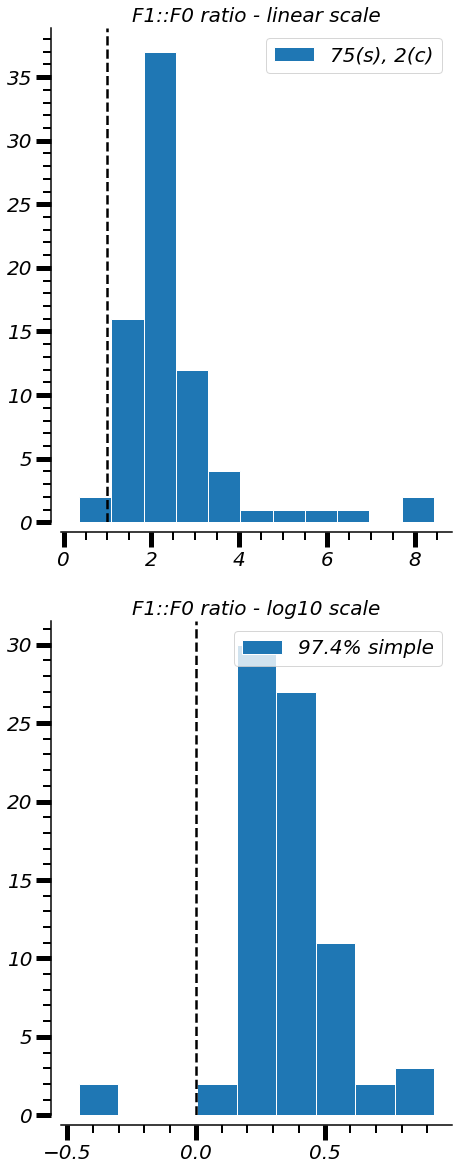

In [32]:
nRows = 2
f, ax = plt.subplots(nRows, 1, figsize=(1*7, nRows*10))

nS, nC = sum(f1f0_rats>1), sum(f1f0_rats<1)
ax[0].hist(hf.nan_rm(f1f0_rats), bins=11, label='%d(s), %d(c)' % (nS, nC));
ax[0].axvline(1.0, ls='--', color='k');
ax[0].set_title('F1::F0 ratio - linear scale')
ax[0].legend();

fracS = nS/(nS+nC);
bins = ax[1].hist(hf.nan_rm(np.log10(f1f0_rats)), bins=9, label='%.1f%% simple' % (100*fracS))[1];
ax[1].axvline(0, ls='--', color='k');
ax[1].set_title('F1::F0 ratio - log10 scale')
ax[1].legend();

sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + f1f0_saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


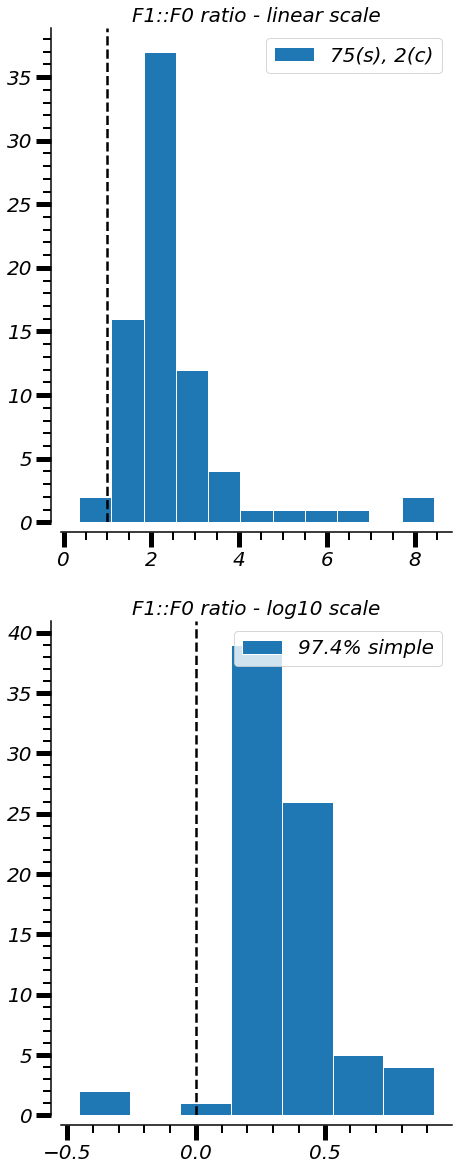

In [33]:
nRows = 2
f, ax = plt.subplots(nRows, 1, figsize=(1*7, nRows*10))

nS, nC = sum(f1f0_rats>1), sum(f1f0_rats<1)
ax[0].hist(hf.nan_rm(f1f0_rats), bins=11, label='%d(s), %d(c)' % (nS, nC));
ax[0].axvline(1.0, ls='--', color='k');
ax[0].set_title('F1::F0 ratio - linear scale')
ax[0].legend();

fracS = nS/(nS+nC);
bins = ax[1].hist(hf.nan_rm(np.log10(f1f0_rats)), bins=7, label='%.1f%% simple' % (100*fracS))[1];
ax[1].axvline(0, ls='--', color='k');
ax[1].set_title('F1::F0 ratio - log10 scale')
ax[1].legend();

sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + f1f0_saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


From the above plots, we can see that the f1/f0 ratios in my V1 dataset are comparable to Cavanaugh's, both in "sign" and magnitude

In [34]:
f1f0tuning_name = 'f1f0_tuning.pdf';

In [35]:
# using for colors
zTO1 = lambda x: np.divide(x - np.nanmin(x), np.nanmax(x - np.nanmin(x)));

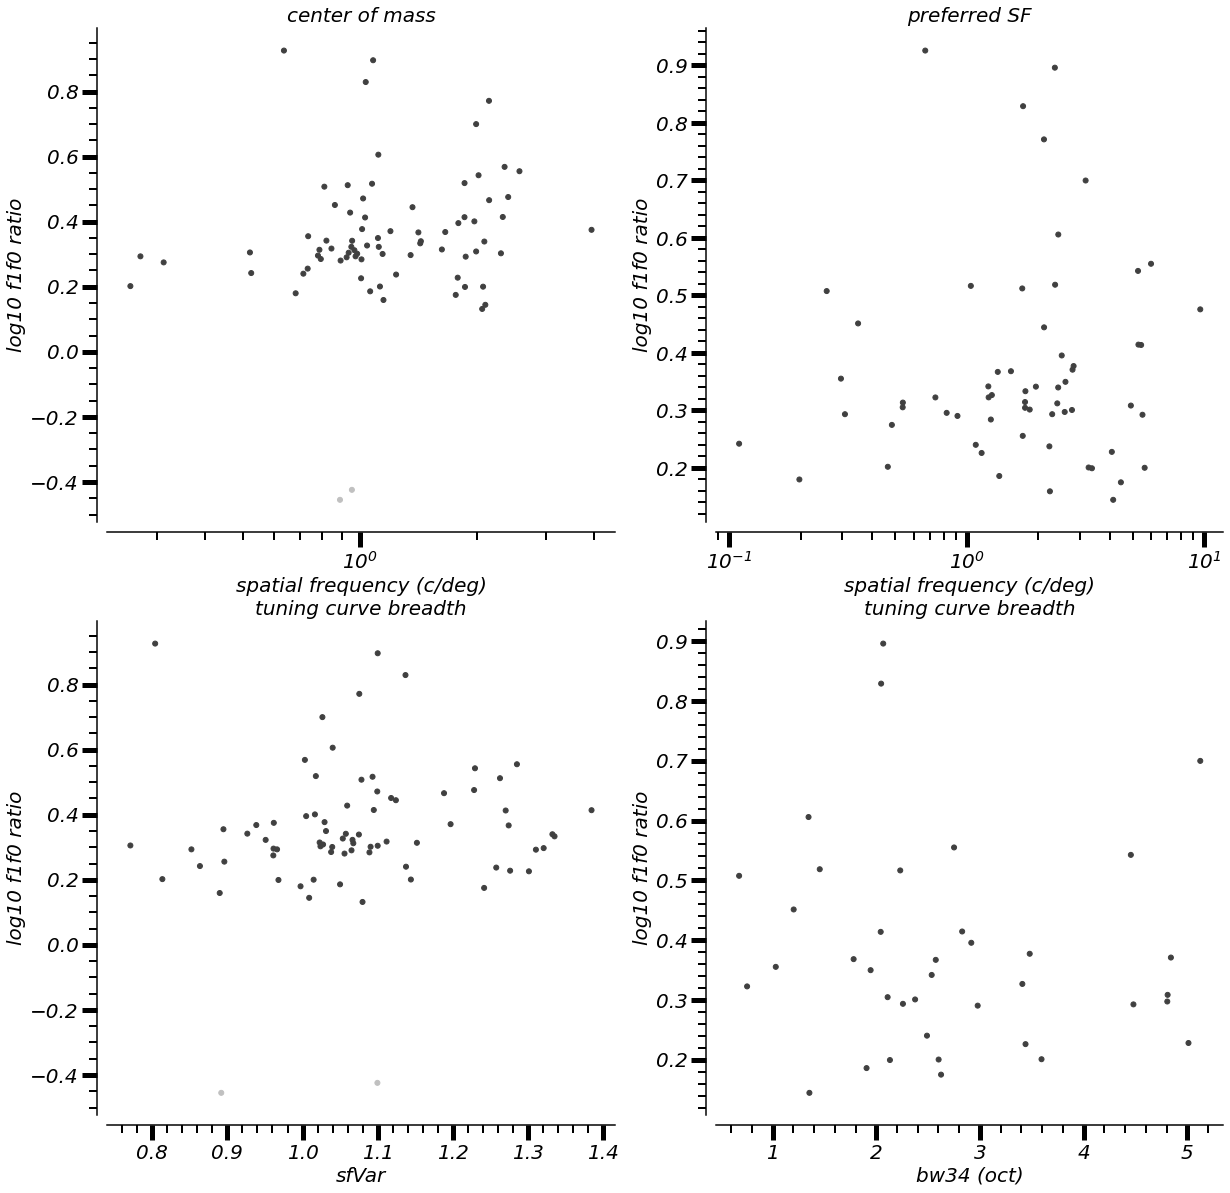

In [36]:
nCols = 2; # each of the below measures will have two types to analyze
nMeasure = 2; # central tendency of SF, variance of S

f, ax = plt.subplots(nMeasure, nCols, figsize=(10*nCols, 10*nMeasure));
# we'll color each point according to the log10'd f1f0 ratio (this scale is more uniform)
log10_f1f0rats = np.log10(f1f0_rats);
clrs = cm.gray(np.ones_like(log10_f1f0rats) - 0.75);
lt0 = np.where(log10_f1f0rats < 0)[0];
clrs[lt0, :] = cm.gray(np.ones_like(lt0) - 0.25);
# clrs = cm.gray(zTO1(log10_f1f0rats));

# first, C.o.M. and pSF
metrics = [comHighCon, pSfHighCon];
labels = ['center of mass', 'preferred SF'];
for ind, (m, l) in enumerate(zip(metrics, labels)):
    ax[0, ind].scatter(m, log10_f1f0rats, color=clrs)
    ax[0, ind].set_ylabel('log10 f1f0 ratio');
    ax[0, ind].set_xlabel('spatial frequency (c/deg)');
    ax[0, ind].set_title('%s' % l)
    ax[0, ind].set_xscale('log')

# second, sfVar and bw34
metrics = [varHighCon, bw34HighCon];
labels = ['sfVar', 'bw34 (oct)'];
for ind, (m, l) in enumerate(zip(metrics, labels)):
    ax[1, ind].scatter(m, log10_f1f0rats, color=clrs)
    ax[1, ind].set_ylabel('log10 f1f0 ratio');
    ax[1, ind].set_xlabel('%s' % l);
    ax[1, ind].set_title('tuning curve breadth')
    
sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + f1f0tuning_name);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


## Shifts in tuning with contrast

### Preferred spatial frequency with contrast inferred from descriptive fit to pSf vs. con

Now, we plot the ratio of preferred spatial frequencies in the data set. Here, we are using "pSfModRat" - a derived measure in which we fit a simple polynomial equation to the preferred frequencies as a function of contrast (see descr_fits.py for details).

- In [0, 0], the ratio of preferred spatial frequencies ($\frac{con_a}{con_b}$) evaluated at the extrema contrasts
- In [0, 1], the ratio of preferred spatial frequencies is expressed per unit log2 contrast

In [157]:
centerBin = 1; # if 1, then the middle bin will be centered at 0

if centerBin == 1:
    bins = np.linspace(-1.25, 1.25, 10);
    binSuffix = '_verAlt'
else: # if 0, then there is a bin on eitiher side of 0
    bins = np.linspace(-1.25, 1.25, 11);
    binSuffix = '';

saveName = 'sfAllConRatioMod_%s%s.pdf' % (fitBase, binSuffix)

# [0, 0] for single gratings, ratio
# [0, 1] for single gratings, ratio per unit log2 contrast
psfModRats = [jointList[i]['metrics']['pSfModRat'][0, 1] for i in range(len(jointList))];
psfModRats = np.array(psfModRats);

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
psfClipped = np.clip(psfModRats, bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

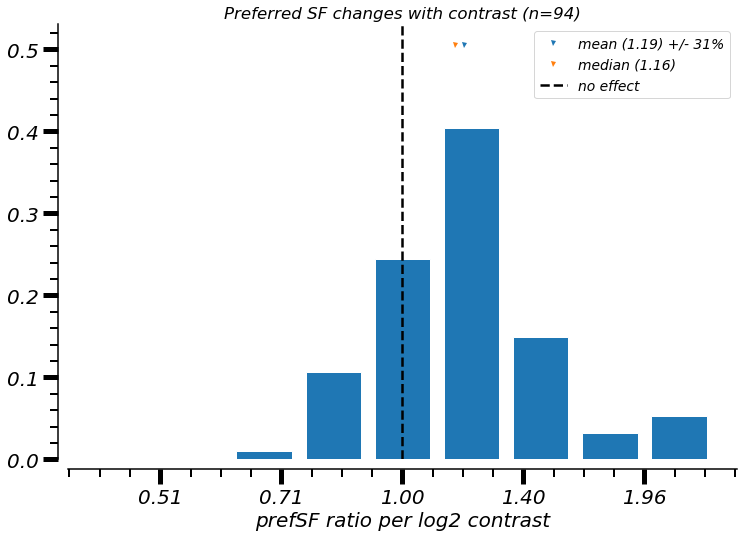

In [158]:
f = plt.figure(figsize=(12, 8))

vals, _ = np.histogram(psfClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(psfModRats), np.nanmedian(psfModRats)];
std = np.nanstd(psfModRats);
stdAsRatio = std/np.power(2, mean);
plt.plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
plt.plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median));
plt.axvline(0, ls='--', c='k', label='no effect')
plt.legend(fontsize='x-small');
plt.xticks(tickVals, ['%.2f' % np.power(2, x) for x in tickVals]);
plt.xlabel('prefSF ratio per log2 contrast');
plt.title('Preferred SF changes with contrast (n=%d)' % sum(vals), fontsize='small');
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

...aside: suppose want to look at cells where the ratio shift is in the top 25% (i.e. highest):

m675r06: flat|wght is (nan|nan)
m675r08: flat|wght is (nan|nan)
m675r26: flat|wght is (nan|nan)
m675r38: flat|wght is (nan|nan)
m675r39: flat|wght is (nan|nan)
m675r49: flat|wght is (nan|nan)
m675r51: flat|wght is (nan|nan)
m680p01r04#5: flat|wght is (nan|nan)
m680p01r06#4: flat|wght is (nan|nan)
m680p01r07#5: flat|wght is (nan|nan)
m680p01r20#7: flat|wght is (nan|nan)
m680p02r38#12: flat|wght is (nan|nan)
m680p07r66#11: flat|wght is (nan|nan)
contxsf3: flat|wght is (nan|nan)
contxsf3: flat|wght is (nan|nan)
contxsf3: flat|wght is (nan|nan)
contxsf3: flat|wght is (nan|nan)
contxsf3: flat|wght is (nan|nan)
contxsf3: flat|wght is (nan|nan)
contxsf3: flat|wght is (nan|nan)
contxsf3: flat|wght is (nan|nan)
contxsf3: flat|wght is (nan|nan)
contxsf3: flat|wght is (nan|nan)
contxsfxsize3: flat|wght is (nan|nan)


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


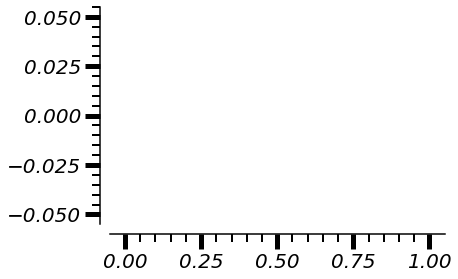

In [43]:
nan_rm = lambda x: x[~np.isnan(x)]

prctile = 75;
thresh = np.percentile(nan_rm(psfModRats), prctile)
# thresh = np.percentile(np.abs(nan_rm(psfRats)), prctile)
shiftCells = np.where(psfModRats>thresh)[0]

allChiDiffs = [];

for i in shiftCells:
    currEntry = jointList[i];
    currName = currEntry['metadata']['expName'];
    try:
        flat, wght = currEntry['model']['NLL_flat'], currEntry['model']['NLL_wght'];
        chiSqDiff = flat-wght;
        allChiDiffs.append(chiSqDiff);
        print('%s: flat|wght is (%.2f|%.2f)' % (currName, flat, wght));
    except: # no fit for this cell
        pass
    
sns.distplot(allChiDiffs, kde=False);
sns.despine(offset=10);

### Preferred spatial frequency with contrast from data, 1:.33 contrast

In [69]:
centerBin = 1; # if 1, then the middle bin will be centered at 0

if centerBin == 1:
    bins = np.linspace(-1.25, 1.25, 10);
    binSuffix = '_verAlt'
else: # if 0, then there is a bin on eitiher side of 0
    bins = np.linspace(-1.25, 1.25, 11);
    binSuffix = '';

saveName = 'sfFixConRatioNorm_%s%s.pdf' % (fitBase, binSuffix);
saveName_scatter = 'sfFixConRatioNorm_scatter_%s%s.pdf' % (fitBase, binSuffix);

# get psfRatio 1:.33 contrast (raw value, not norm. to con value)
disp = 0; # i.e. single gratings
toNorm = 0;
if toNorm == 1:
    conNorm = np.log2(1/0.33);
else:
    conNorm = 1;
    
# why ['diffsAtThirdCon'][2] - [2] is pSf
psfRats = [jointList[i]['metrics']['diffsAtThirdCon'][disp, 2]/conNorm for i in range(len(jointList))];
psfRats = np.array(psfRats);

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
psfClipped = np.clip(psfRats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

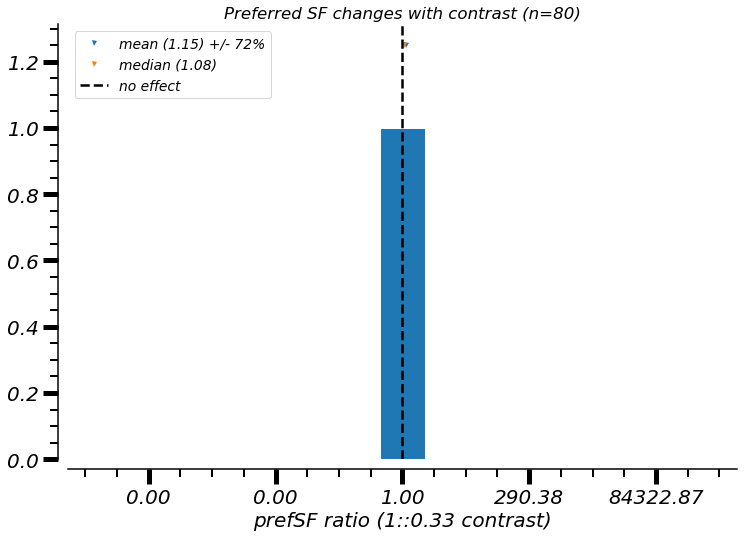

In [156]:
f = plt.figure(figsize=(12, 8))

vals, _ = np.histogram(psfClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(psfRats), np.nanmedian(psfRats)];
std = np.nanstd(psfRats);
stdAsRatio = std/np.power(2, mean);
plt.plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
plt.plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median));
plt.axvline(0, ls='--', c='k', label='no effect')
plt.legend(fontsize='x-small', loc='upper left');
plt.xticks(tickVals, ['%.2f' % np.power(2, x) for x in tickVals]);
plt.xlabel('prefSF ratio (1::0.33 contrast)');
plt.title('Preferred SF changes with contrast (n=%d)' % sum(vals), fontsize='small');
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### Are these differences significant?
The way to test this is a paired t-test, since want to know if the two samples of the metric (e.g. preferred frequency at two different contrasts) have a different mean.

In [74]:
highCon = hf.jl_get_metric_byCon(jointList, 'pSf', conVal=1.0, disp=0)
lowCon  = hf.jl_get_metric_byCon(jointList, 'pSf', conVal=0.33, disp=0)
non_nan = np.logical_and(~np.isnan(highCon), ~np.isnan(lowCon));

In [75]:
paired_t = ss.ttest_rel(highCon[non_nan], lowCon[non_nan])
pval = paired_t.pvalue;
if pval <= 0.05:
    print('significant! p=%.2e (n=%d)' % (pval, sum(non_nan)));
elif paired_t.pvalue > 0.05:
    print('not significant! p=%.2e (n=%d)' % (pval, sum(non_nan)));

not significant! p=9.06e-02 (n=55)


## Scatter plots!

### 0a. Model - variance explained

### Copy from descrAnalysisV1-allExps if needed in the future

### 0b. Variance explained, but only single gratings

### 0c. Only mixtures

### 1. Preferred spatial frequency with contrast from data (1:.33 contrast and 1:lowestValid contrast)

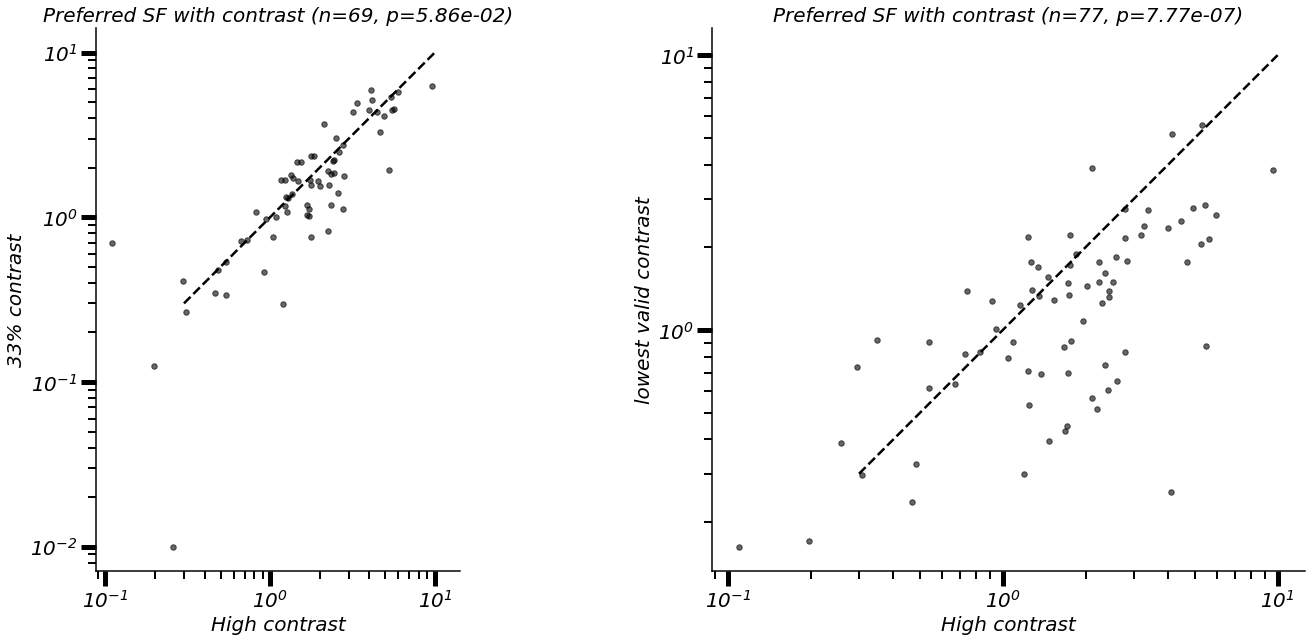

In [150]:
saveName = 'sfConScatter_%s.pdf' % (fitBase);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    highInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,0] for x in range(len(jointList))]);
    # compInd will first be at one third (when i==0), then at lowest valid contrast...
    compInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,i+1] for x in range(len(jointList))]);
    
    highSf = np.array([jointList[x]['metrics']['pSf'][disp, hI] for x,hI in enumerate(highInd)])
    compSf = np.array([jointList[x]['metrics']['pSf'][disp, cI] for x,cI in enumerate(compInd)])

    non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
    excl_ind = np.where(highInd == compInd)[0]; # only will come into play for case 2 -- places where the lowest valid contrast is also the highest contrast!
    val_inds = np.setdiff1d(np.where(non_nan)[0], excl_ind);
    
    ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([0.3,10], [0.3, 10], 'k--')
    paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('Preferred SF with contrast (n=%d, p=%.2e)' % (len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 1b. sf70 with contrast from data (1:.33 contrast and 1:lowestValid contrast)

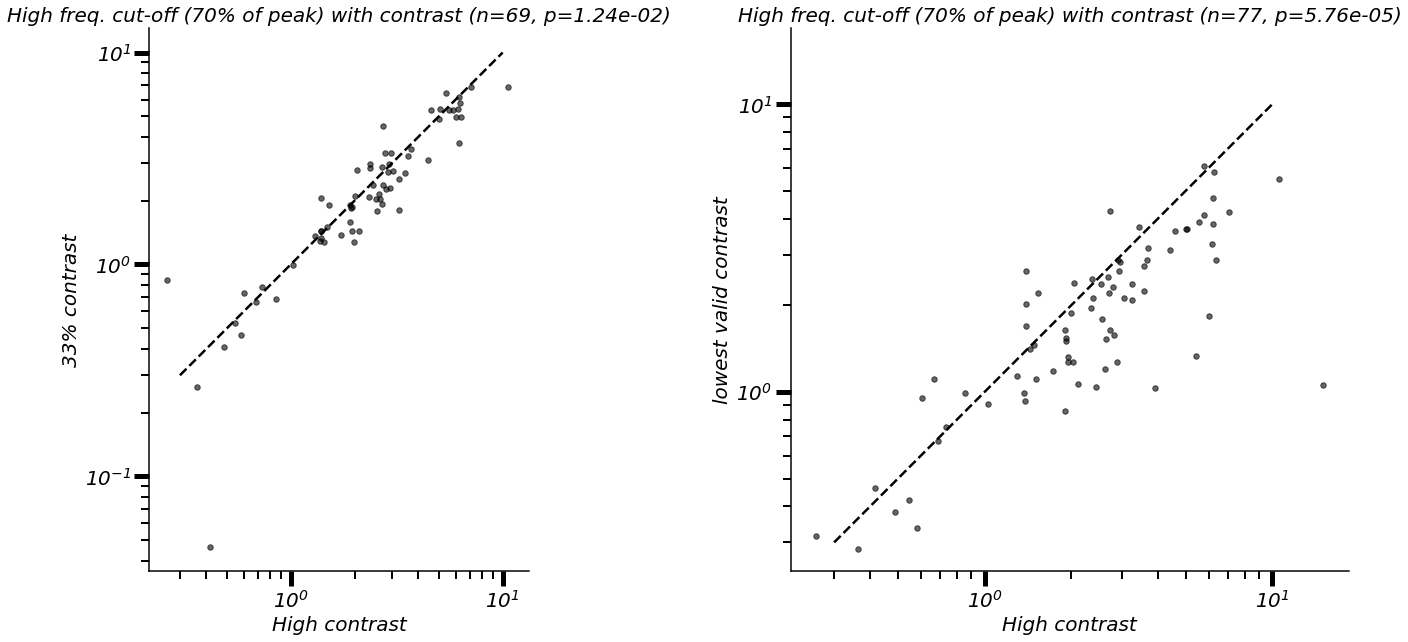

In [151]:
saveName = 'sf70ConScatter_%s.pdf' % (fitBase);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    highInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,0] for x in range(len(jointList))]);
    # compInd will first be at one third (when i==0), then at lowest valid contrast...
    compInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,i+1] for x in range(len(jointList))]);
    
    highSf = np.array([jointList[x]['metrics']['sf70'][disp, hI] for x,hI in enumerate(highInd)])
    compSf = np.array([jointList[x]['metrics']['sf70'][disp, cI] for x,cI in enumerate(compInd)])

    non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
    excl_ind = np.where(highInd == compInd)[0]; # only will come into play for case 2 -- places where the lowest valid contrast is also the highest contrast!
    val_inds = np.setdiff1d(np.where(non_nan)[0], excl_ind);
    
    ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([0.3,10], [0.3, 10], 'k--')
    paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('High freq. cut-off (70%% of peak) with contrast (n=%d, p=%.2e)' % (len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [152]:
highSf[73]

0.36257745977579303

In [153]:
compSf[73]

0.28419692909209504

### 1c. Characteristic frequency with contrast from data (1:.33 contrast and 1:lowestValid contrast)

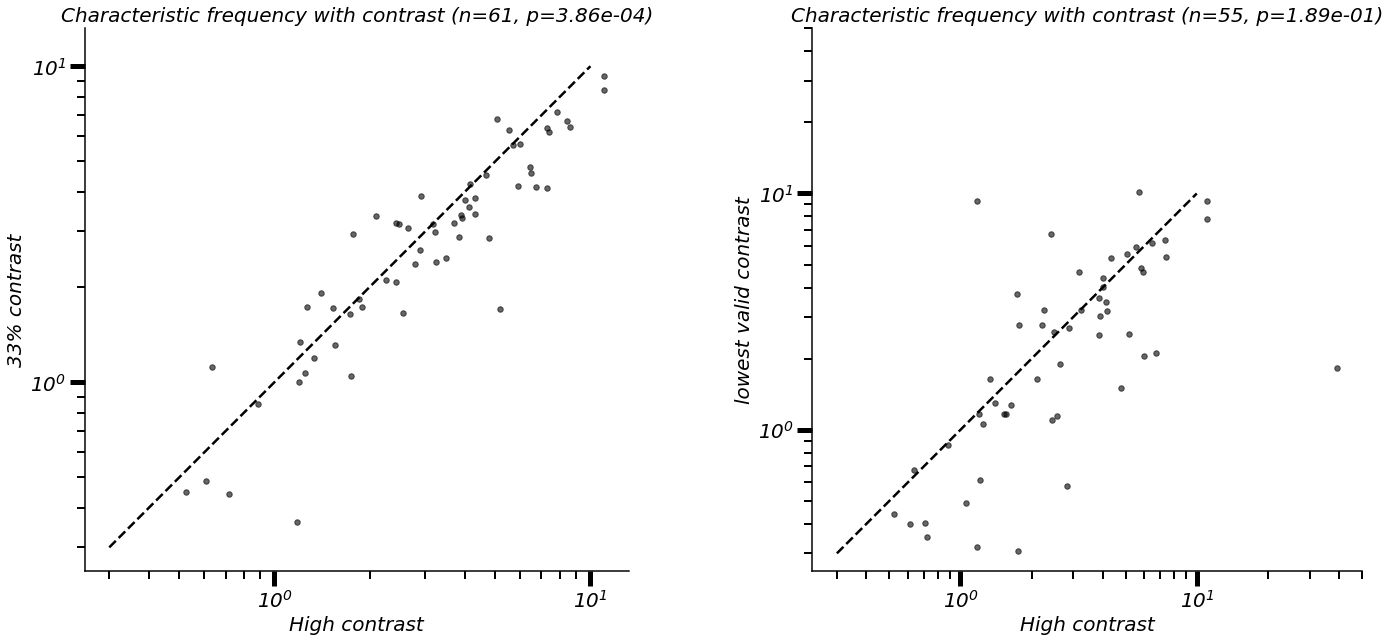

In [154]:
saveName = 'charFreqConScatter_%s.pdf' % (fitBase);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    highInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,0] for x in range(len(jointList))]);
    # compInd will first be at one third (when i==0), then at lowest valid contrast...
    compInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,i+1] for x in range(len(jointList))]);
    
    highSf = np.array([jointList[x]['metrics']['dog_charFreq'][disp, hI] for x,hI in enumerate(highInd)])
    compSf = np.array([jointList[x]['metrics']['dog_charFreq'][disp, cI] for x,cI in enumerate(compInd)])

    non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
    excl_ind = np.where(highInd == compInd)[0]; # only will come into play for case 2 -- places where the lowest valid contrast is also the highest contrast!
    val_inds = np.setdiff1d(np.where(non_nan)[0], excl_ind);
    
    ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([0.3,10], [0.3, 10], 'k--')
    paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('Characteristic frequency with contrast (n=%d, p=%.2e)' % (len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 1d. dog_sf70 with contrast from data (1:.33 contrast and 1:lowestValid contrast)

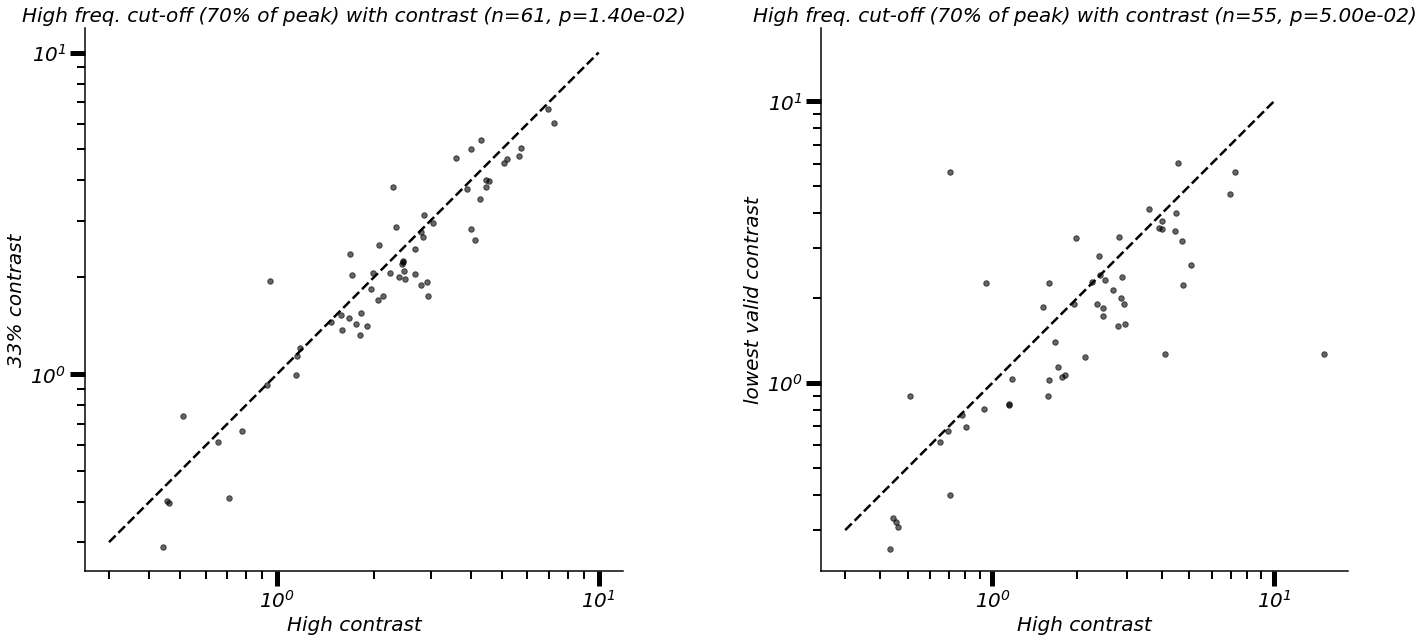

In [155]:
saveName = 'dog_sf70ConScatter_%s.pdf' % (fitBase);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    highInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,0] for x in range(len(jointList))]);
    # compInd will first be at one third (when i==0), then at lowest valid contrast...
    compInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,i+1] for x in range(len(jointList))]);
    
    highSf = np.array([jointList[x]['metrics']['dog_sf70'][disp, hI] for x,hI in enumerate(highInd)])
    compSf = np.array([jointList[x]['metrics']['dog_sf70'][disp, cI] for x,cI in enumerate(compInd)])

    non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
    excl_ind = np.where(highInd == compInd)[0]; # only will come into play for case 2 -- places where the lowest valid contrast is also the highest contrast!
    val_inds = np.setdiff1d(np.where(non_nan)[0], excl_ind);
    
    ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([0.3,10], [0.3, 10], 'k--')
    paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('High freq. cut-off (70%% of peak) with contrast (n=%d, p=%.2e)' % (len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 2. Bandwidth

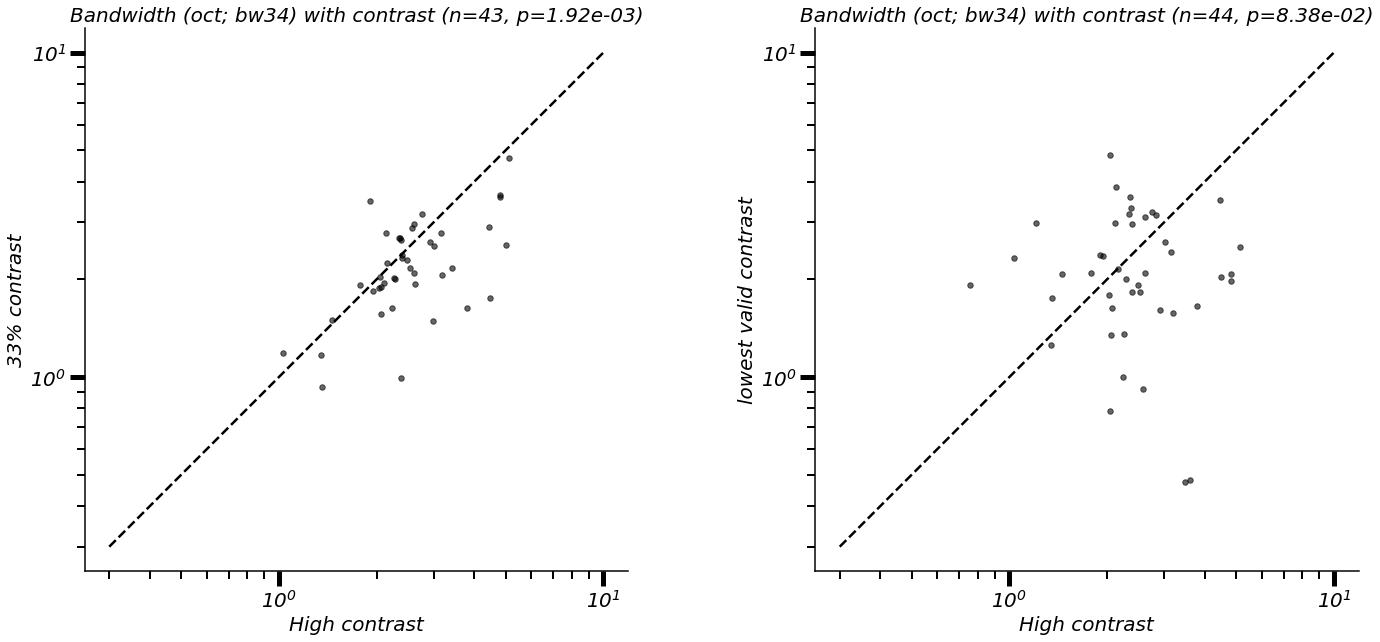

In [143]:
whichBw = 1;
bwStr = 'bwHalf' if whichBw == 0 else 'bw34';
saveName = '%sConScatter_%s.pdf' % (bwStr, fitBase);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    highInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,0] for x in range(len(jointList))]);
    # compInd will first be at one third (when i==0), then at lowest valid contrast...
    compInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,i+1] for x in range(len(jointList))]);
    
    highVal = np.array([jointList[x]['metrics'][bwStr][disp, hI] for x,hI in enumerate(highInd)])
    compVal = np.array([jointList[x]['metrics'][bwStr][disp, cI] for x,cI in enumerate(compInd)])

    non_nan = np.logical_and(~np.isnan(highVal), ~np.isnan(compVal))
    excl_ind = np.where(highInd == compInd)[0]; # only will come into play for case 2 -- places where the lowest valid contrast is also the highest contrast!
    val_inds = np.setdiff1d(np.where(non_nan)[0], excl_ind);
    
    ax[i].scatter(highVal[val_inds], compVal[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([3e-1, 10], [3e-1, 10], 'k--')
    paired_t = ss.ttest_rel(highVal[val_inds], compVal[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('Bandwidth (oct; %s) with contrast (n=%d, p=%.2e)' % (bwStr, len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [144]:
highVal[73], compVal[73]

(nan, 1.3202538738597134)

### 3. Bandwidth - only one half

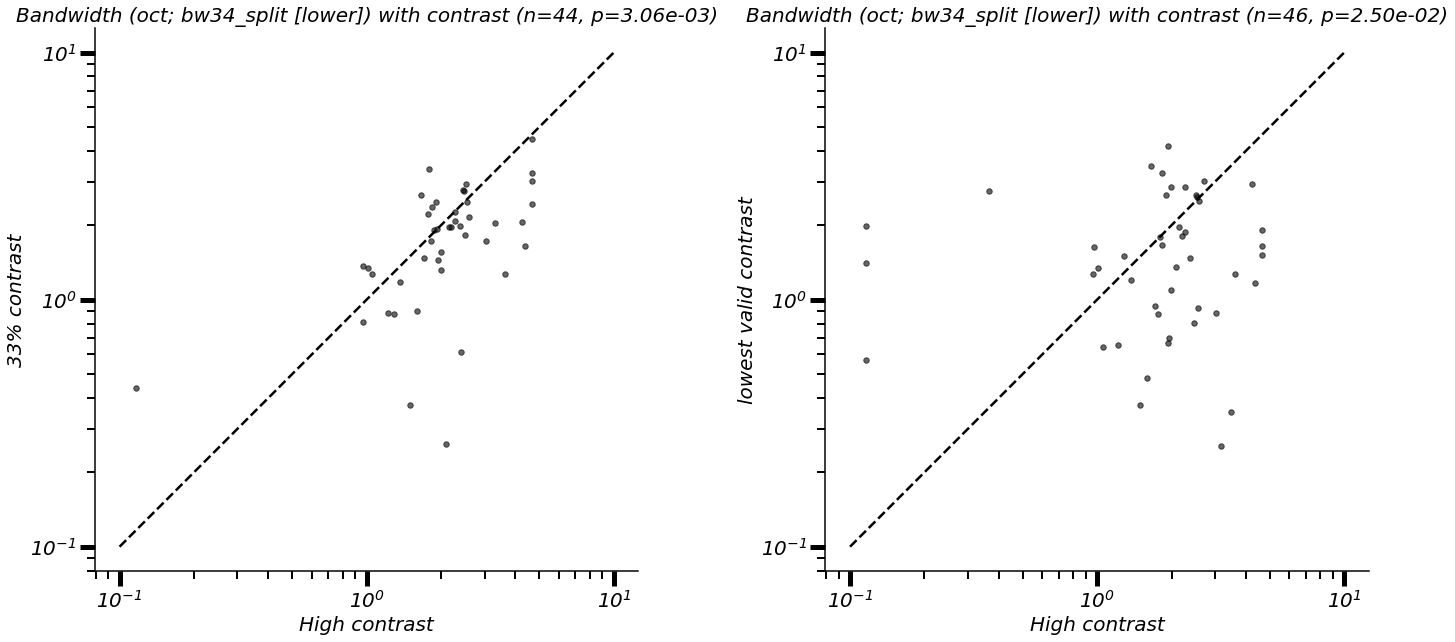

In [148]:
whichBw = 1;
whichHalf = 0; # 0 is lower, 1 is upper
bwStr = 'bwHalf_split' if whichBw == 0 else 'bw34_split';
halfLabel = 'lower' if whichHalf == 0 else 'upper'
saveName = '%s_%s_ConScatter_%s.pdf' % (bwStr, halfLabel, fitBase);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    highInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,0] for x in range(len(jointList))]);
    # compInd will first be at one third (when i==0), then at lowest valid contrast...
    compInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,i+1] for x in range(len(jointList))]);
    
    highVal = np.array([jointList[x]['metrics'][bwStr][disp, hI, whichHalf] for x,hI in enumerate(highInd)])
    compVal = np.array([jointList[x]['metrics'][bwStr][disp, cI, whichHalf] for x,cI in enumerate(compInd)])

    non_nan = np.logical_and(~np.isnan(highVal), ~np.isnan(compVal))
    excl_ind = np.where(highInd == compInd)[0]; # only will come into play for case 2 -- places where the lowest valid contrast is also the highest contrast!
    val_inds = np.setdiff1d(np.where(non_nan)[0], excl_ind);
    
    ax[i].scatter(highVal[val_inds], compVal[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([1e-1, 10], [1e-1, 10], 'k--')     
    paired_t = ss.ttest_rel(highVal[val_inds], compVal[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('Bandwidth (oct; %s [%s]) with contrast (n=%d, p=%.2e)' % (bwStr, halfLabel, len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [149]:
highVal[73], compVal[73]

(nan, 0.6569170573717653)

### 4. Bandwidth - by halves, showing relative change in each half

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


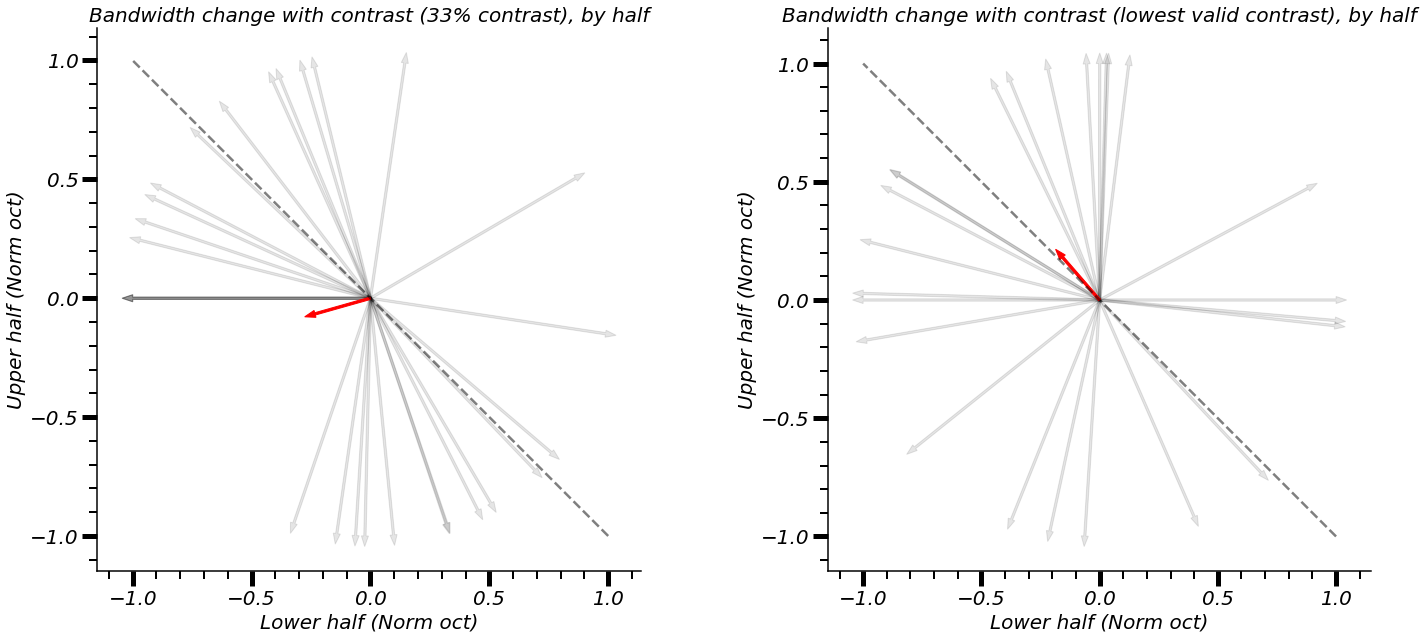

In [127]:
whichBw = 0;
fromOrigin = 1; # if 0, we just show the vec from hi to comp con; if 1, we center all vectors at origin
normOct = 1; # normalize lower/upper half to the oct bandwidth at high contrast
unitVecs = 1; # if unit vectors, every change will have length of 1

arrowWidth = 0.01
bwStr = 'bwHalf_split' if whichBw == 0 else 'bw34_split';
originStr = '' if fromOrigin == 0 else 'Origin'
normStr = 'Norm' if normOct else '';
unitStr = 'UnitVec' if unitVecs else '';

saveName = '%s_traj%s%s%s_%s.pdf' % (bwStr, originStr, normStr, unitStr, fitBase);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    highInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,0] for x in range(len(jointList))]);
    # compInd will first be at one third (when i==0), then at lowest valid contrast...
    compInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,i+1] for x in range(len(jointList))]);
    
    highVecOrig = np.array([jointList[x]['metrics'][bwStr][disp, hI, :] for x,hI in enumerate(highInd)])
    compVecOrig = np.array([jointList[x]['metrics'][bwStr][disp, cI, :] for x,cI in enumerate(compInd)])

    if normOct:
        highVec = np.divide(highVecOrig, highVecOrig)
        compVec = np.divide(compVecOrig, highVecOrig)
    else:
        highVec = highVecOrig
        compVec = compVecOrig
    if normOct:
        vecChange = np.log2(compVec)
    else:
        vecChange = -highVec+compVec
    if unitVecs:
        vecChange = np.array([curr / np.linalg.norm(curr) for curr in vecChange])
   
    
    if fromOrigin:
        [ax[i].arrow(0,0,*vecCh, width=arrowWidth, color='k', alpha=0.1) for vecCh in vecChange]
        ax[i].plot([1,-1],[-1,1], 'k--', alpha=0.5)
        meanChange = np.nanmean(vecChange, axis=0);
        ax[i].arrow(0,0,*meanChange, width=arrowWidth, color='r', alpha=1)
    else:
        [ax[i].arrow(*high,*vecCh, width=arrowWidth, color='k', alpha=0.1) for high,vecCh in zip(highVec, vecChange)]
    ax[i].set_xlabel('Lower half (%s oct)' % normStr)
    ax[i].set_ylabel('Upper half (%s oct)' % normStr)
    ax[i].set_title('Bandwidth change with contrast (%s), by half' % ylbl)
#     ax[i].set_xlabel('High contrast')
#     ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [131]:
jointList[73]['metrics'].keys()

dict_keys(['sfCom', 'sfComCut', 'sfVar', 'f1f0_ratio', 'lsfv', 'bwHalf', 'bwHalf_split', 'bw34', 'bw34_split', 'pSf', 'sf70', 'dog_sf70', 'sf75', 'dog_sf75', 'sfE', 'dog_sfE', 'c50', 'c50_emp', 'c50_eval', 'c50_varExpl', 'dog_pSf', 'dog_charFreq', 'dog_varExpl', 'bwHalfDiffs', 'bwHalfDiffs_split', 'bw34Diffs', 'bw34Diffs_split', 'lsfvRats', 'pSfRats', 'pSfModRat', 'sf70Rats', 'sf70ModRat', 'dog_sf70Rats', 'dog_sf70ModRat', 'sf75Rats', 'sf75ModRat', 'dog_sf75Rats', 'dog_sf75ModRat', 'sfERats', 'sfEModRat', 'dog_sfERats', 'dog_sfEModRat', 'sfVarDiffs', 'sfComRats', 'sfVarExpl', 'c50Rats', 'suppressionIndex', 'diffsAtThirdCon', 'diffsAtThirdCon_bwSplit', 'diffsAtThirdCon_lsfv', 'relDescr_inds', 'mn_med_max'])

### 5. LSFV (per Xing et al, 2004)

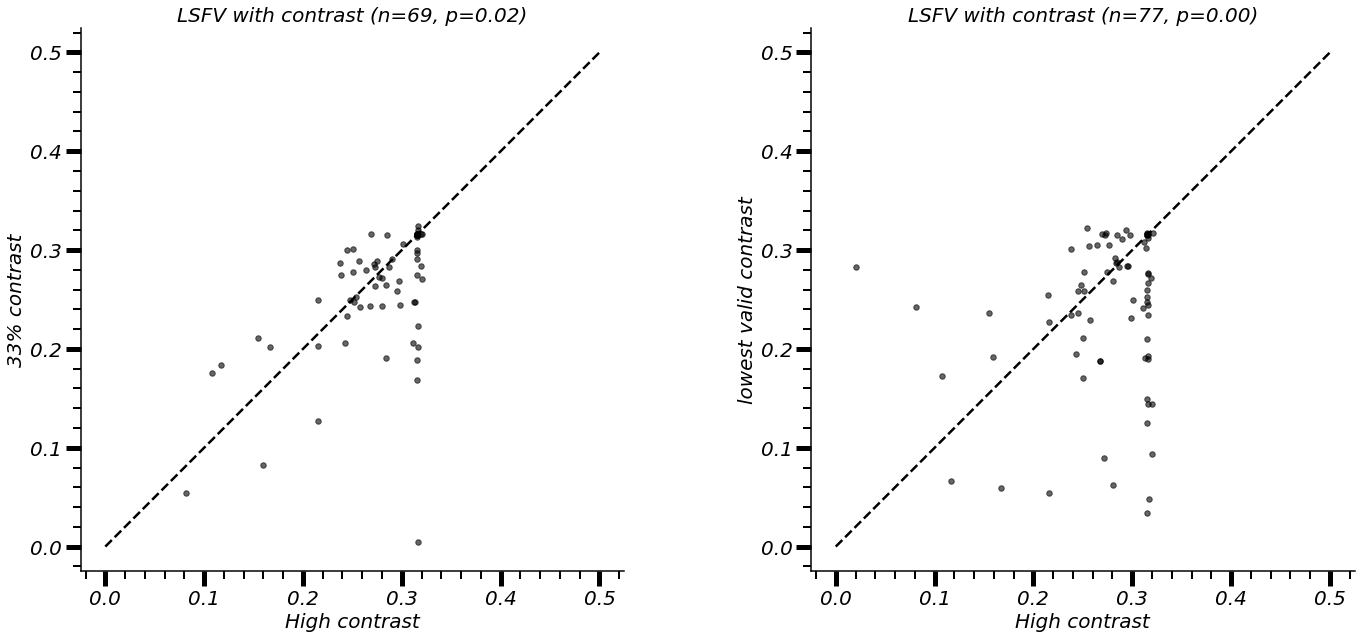

In [59]:
saveName = 'LSFV_ConScatter_%s.pdf' % (fitBase);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    highInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,0] for x in range(len(jointList))]);
    # compInd will first be at one third (when i==0), then at lowest valid contrast...
    compInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,i+1] for x in range(len(jointList))]);
    
    highVal = np.array([jointList[x]['metrics']['lsfv'][disp, hI] for x,hI in enumerate(highInd)])
    compVal = np.array([jointList[x]['metrics']['lsfv'][disp, cI] for x,cI in enumerate(compInd)])

    non_nan = np.logical_and(~np.isnan(highVal), ~np.isnan(compVal))
    excl_ind = np.where(highInd == compInd)[0]; # only will come into play for case 2 -- places where the lowest valid contrast is also the highest contrast!
    val_inds = np.setdiff1d(np.where(non_nan)[0], excl_ind);
    
    ax[i].scatter(highVal[val_inds], compVal[val_inds], alpha=0.6, color='k', s=30)
    ax[i].plot([0, 0.5], [0, 0.5], 'k--')
    paired_t = ss.ttest_rel(highVal[val_inds], compVal[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('LSFV with contrast (n=%d, p=%.2f)' % (len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### ...done with scatter plots, for now

### But now with center of mass!

In [60]:
# get psfRatio 1:.33 contrast (raw value, not norm. to con value)
disp = 0; # i.e. single gratings

toNorm = 0;
if toNorm == 1:
    conNorm = np.log2(1/0.33);
    normStr = 'Norm'
else:
    conNorm = 1;
    normStr = ''

saveName = 'sfComFixConRatio%s_%s.pdf' % (normStr, fitBase);
    
# why ['diffsAtThirdCon'][4] - [4] is center of mass ratio
comRats = [jointList[i]['metrics']['diffsAtThirdCon'][disp, 4]/conNorm for i in range(len(jointList))];
comRats = np.array(comRats);

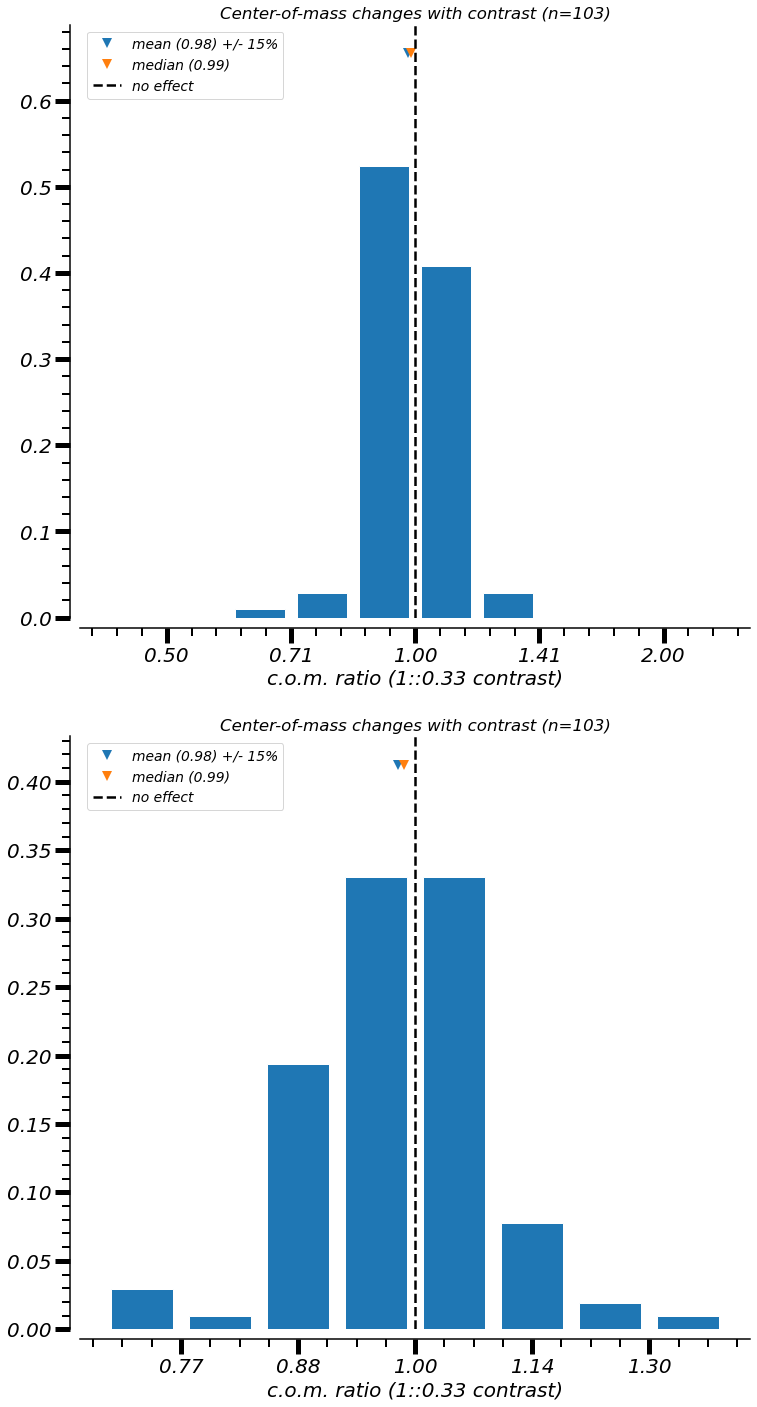

In [61]:
f, ax = plt.subplots(2, 1, figsize=(12, 2*12))

### same scale as pSf above
bins = np.linspace(-1.25, 1.25, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
comClipped = np.clip(comRats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(comClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[0].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(comRats), np.nanmedian(comRats)];
std = np.nanstd(comRats);
stdAsRatio = std/np.power(2, mean);
ax[0].plot(mean, 1.25*np.max(vals_norm), 'v', markersize=10, label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
ax[0].plot(median, 1.25*np.max(vals_norm), 'v', markersize=10, label='median (%.2f)' % np.power(2, median));
ax[0].axvline(0, ls='--', c='k', label='no effect')
ax[0].legend(fontsize='x-small', loc='upper left');
ax[0].set_xticks(tickVals)
ax[0].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);
ax[0].set_xlabel('c.o.m. ratio (1::0.33 contrast)');
ax[0].set_title('Center-of-mass changes with contrast (n=%d)' % sum(vals), fontsize='small');
sns.despine(offset=10)

### better scale given range of c.o.m.
bins = np.linspace(-0.5, 0.5, 9);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
comClipped = np.clip(comRats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(comClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(comRats), np.nanmedian(comRats)];
std = np.nanstd(comRats);
stdAsRatio = std/np.power(2, mean);
ax[1].plot(mean, 1.25*np.max(vals_norm), 'v', markersize=10, label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
ax[1].plot(median, 1.25*np.max(vals_norm), 'v', markersize=10, label='median (%.2f)' % np.power(2, median));
ax[1].axvline(0, ls='--', c='k', label='no effect')
ax[1].legend(fontsize='x-small', loc='upper left');
ax[1].set_xticks(tickVals);
ax[1].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);
ax[1].set_xlabel('c.o.m. ratio (1::0.33 contrast)');
ax[1].set_title('Center-of-mass changes with contrast (n=%d)' % sum(vals), fontsize='small');
sns.despine(offset=10)


if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### Are these differences significant?

In [ ]:
highCon = hf.jl_get_metric_byCon(jointList, 'sfCom', conVal=1.0, disp=0)
lowCon  = hf.jl_get_metric_byCon(jointList, 'sfCom', conVal=0.33, disp=0)
non_nan = np.logical_and(~np.isnan(highCon), ~np.isnan(lowCon));

In [ ]:
paired_t = ss.ttest_rel(highCon[non_nan], lowCon[non_nan])
pval = paired_t.pvalue;
if pval <= 0.05:
    print('significant! p=%.2e (n=%d)' % (pval, sum(non_nan)));
elif paired_t.pvalue > 0.05:
    print('not significant! p=%.2e (n=%d)' % (pval, sum(non_nan)));

### Bandwidth with contrast from data, 1:.33 contrast

In [ ]:
saveBase = lambda s: 'bwFixedCons%s_%s.pdf' % (s, fitBase);

disp = 0; # looking at single gratings
# get bw diff 1:.33 contrast (raw value, not norm. to con value)
bwAt = 0; # 0 - half-height; 1 - 3/4 height

bwStr = ['1/2 ht', '3/4 ht'];
bwSaveStr = ['_hh', '_3qh'];

bwDiff = [jointList[i]['metrics']['diffsAtThirdCon'][disp, bwAt] for i in range(len(jointList))];
bwDiff = np.array(bwDiff);

bins = np.linspace(-2.5, 2.5, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
bwClipped = np.clip(bwDiff, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

In [ ]:
np.argsort(bwDiff)

In [ ]:
f = plt.figure(figsize=(12, 8))

vals, _ = np.histogram(bwClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(bwDiff), np.nanmedian(bwDiff)];
std = np.nanstd(bwClipped);
# stdAsRatio = 0
stdAsRatio = std/mean;
plt.plot(mean, 1.25*np.max(vals_norm), 'v', markersize=10, label='mean (%.2f) +/- %.0f%%' % (mean, 100*stdAsRatio));
plt.plot(median, 1.25*np.max(vals_norm), 'v', markersize=10, label='median (%.2f)' % median);
plt.axvline(0, ls='--', c='k', label='no effect')
plt.legend(fontsize='x-small');
plt.xlabel('octave bandwidth difference (1::0.33 contrast)');
plt.title('Bandwidth SF changes with contrast (n=%d, %s)' % (sum(vals), bwStr[bwAt]), fontsize='small');
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
saveName = saveBase(bwSaveStr[bwAt])
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [ ]:
# test for significance
metr = ['bwHalf', 'bw34']

for m in metr:

    highCon = hf.jl_get_metric_byCon(jointList, m, conVal=1.0, disp=0)
    lowCon  = hf.jl_get_metric_byCon(jointList, m, conVal=0.33, disp=0)
    non_nan = np.logical_and(~np.isnan(highCon), ~np.isnan(lowCon));

    paired_t = ss.ttest_rel(highCon[non_nan], lowCon[non_nan])
    pval = paired_t.pvalue;
    if pval <= 0.05:
        print('%s: significant! p=%.2e (n=%d)' % (m, pval, sum(non_nan)));
    elif paired_t.pvalue > 0.05:
        print('%s not significant! p=%.2e (n=%d)' % (m, pval, sum(non_nan)));

### Now with model-free metric

In [ ]:
saveBase = lambda s: 'bwVarFixedCons_%s.pdf' % (fitBase);

disp = 0;
# why ['diffsAtThirdCon'][3]? [3] is model-free variance measure
varDiff = [jointList[i]['metrics']['diffsAtThirdCon'][disp, 3] for i in range(len(jointList))];
varDiff = np.array(varDiff);

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(12, 2*12))

### first, same scale as above

bins = np.linspace(-2.5, 2.5, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
varClipped = np.clip(varDiff, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(varClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[0].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(varDiff), np.nanmedian(varDiff)];
std = np.nanstd(varClipped);
# stdAsRatio = 0
stdAsRatio = std/mean;
ax[0].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (mean, 100*stdAsRatio));
ax[0].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % median);
ax[0].axvline(0, ls='--', c='k', label='no effect')
ax[0].legend(fontsize='x-small');
ax[0].set_xlabel('sfVar difference (1::0.33 contrast)');
ax[0].set_title('SF variance changes with contrast (n=%d)' % (sum(vals)), fontsize='small');
sns.despine(offset=10)

### then, better scale for this metric

bins = np.linspace(-0.5, 0.5, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
varClipped = np.clip(varDiff, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(varClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(varDiff), np.nanmedian(varDiff)];
std = np.nanstd(varClipped);
# stdAsRatio = 0
stdAsRatio = std/mean;
ax[1].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (mean, 100*stdAsRatio));
ax[1].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % median);
ax[1].axvline(0, ls='--', c='k', label='no effect')
ax[1].legend(fontsize='x-small');
ax[1].set_xlabel('sfVar difference (1::0.33 contrast)');
ax[1].set_title('SF variance changes with contrast (n=%d)' % (sum(vals)), fontsize='small');
sns.despine(offset=10)

### now save

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
saveName = saveBase(bwSaveStr)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [ ]:
# test for significance
m = 'sfVar'

highCon = hf.jl_get_metric_byCon(jointList, m, conVal=1.0, disp=0)
lowCon  = hf.jl_get_metric_byCon(jointList, m, conVal=0.33, disp=0)
non_nan = np.logical_and(~np.isnan(highCon), ~np.isnan(lowCon));

paired_t = ss.ttest_rel(highCon[non_nan], lowCon[non_nan])
pval = paired_t.pvalue;
if pval <= 0.05:
    print('%s: significant! p=%.2e (n=%d)' % (m, pval, sum(non_nan)));
elif paired_t.pvalue > 0.05:
    print('%s not significant! p=%.2e (n=%d)' % (m, pval, sum(non_nan)));

### Show the trajectory of these measures across all contrasts
Rather than simply analyzing the ratio at any two contrasts, let's consider the evolution of these measures across all contrasts (for a given cell and dispersion)

In [ ]:
#######
# First, decide which measure we're using; prepare plot
#######
subset = ['all', 'halfInt', 'fullInt']

sfMetrics = ['sfCom', 'pSf', 'bwHalf'];
nMetrics = len(sfMetrics);
metricColor = ['k', 'b', 'g']

# allCon_sf  = dict();
# allCon_con = dict();

nCells = len(jointList);

maxCons = np.max([len(jointList[i]['metadata']['stimVals'][1]) for i in range(nCells)]); # max nCons
# dispColor = cm.rainbow(np.linspace(0, 1, maxDisp));

for mtr, mtrClr in zip(sfMetrics, metricColor):

    for sub_ind, sbst in zip(range(len(subset)), subset):
    
        saveName = 'sfTune_conTrends_%s_%s.pdf' % (mtr, sbst)

        #######
        # subset the data
        #######
        
        # first, determine which cells we'll consider
        expInds = np.array([jointList[i]['metadata']['expInd'] for i in range(nCells)])
        if sub_ind == 0: # all data
            # NOTE: yes, we could just grab 'median', but want to track # cells
            ok = np.where(expInds > 0)[0]; # i.e. any experiment...
        elif sub_ind == 1: # sfMixLGN[halfInt/Int]
            ok = np.where((expInds >= 3) & (expInds <= 4))[0]
        elif sub_ind == 2: # sfMix[halfInt/Int]
            ok = np.where((expInds >= 5) & (expInds <= 6))[0]
    
        # how to handle contrast? for each cell, find the contrast that is valid for that dispersion and matches the con_lvl
        # to within some tolerance (e.g. +/- 0.01, i.e. 1% contrast)

        #######
        # set up plot, analyses
        #######
        maxDisp = np.max([len(jointList[i]['metadata']['stimVals'][0]) for i in ok]) # 0 for disps...
        dispColor = cm.rainbow(np.linspace(0, 1, maxDisp));
        f, ax = plt.subplots(maxDisp, 2, figsize=(2*20, nMetrics*20));

        full_slope = [];
        prev_ahh = None; # store previous median slope value

    #     allDisp_sf[con_ind] = dict();
    
        for d, clr in zip(range(maxDisp), dispColor):

            all_sfs = [];
            all_cons = [];
            all_slopes = [];

            for i in ok:

                #######
                # get structure, metadata, etc
                #######
                curr_cell = jointList[i]
                curr_metr = curr_cell['metrics']['%s' % mtr];
                curr_meta = curr_cell['metadata'];
                curr_cons = curr_meta['stimVals'][1];
                curr_byDisp = curr_meta['val_con_by_disp'];
                if d < len(curr_byDisp):
                    curr_inds = curr_byDisp[d];
                else:
                    continue; # i.e. this dispersion isn't ther

                curr_conVals = np.array(curr_cons[curr_inds]);
                curr_metrVal = np.array(curr_metr[d, curr_inds]);

                #######
                # slope measure
                # get a slope for how the metric changes with dispersion...mostly just interested in sign (+/-)
                #######
                non_nan = ~np.isnan(curr_metrVal);
                if np.array_equal(np.unique(non_nan), [False]): # i.e. all are nan
                    curr_slope = np.nan
                else:
                    curr_slope = linregress(np.log2(curr_conVals[non_nan]), curr_metrVal[non_nan])[0];

                all_sfs.append(curr_metrVal);
                all_cons.append(curr_conVals);
                all_slopes.append(curr_slope);

                #######
                # now plot!
                #######

                ax[d, 0].semilogx(curr_conVals, curr_metrVal, linestyle='--', alpha=0.3, color=clr);
                ax[d, 0].set_title('metric: %s' % mtr)

            #######
            # gather for everything, plot
            #######
#             if np.array_equal(all_cons, []):
#                 continue; # what does this mean? When we subset the data, not all dispersions are
            full_slope.append(np.array(all_slopes));

            # now take median, save
            stacked_cons = np.hstack([x for x in all_cons]);
            unique_cons = np.unique(stacked_cons);
            mdn = [];
            for c_lvl in unique_cons:
                ind_byCell = [np.where(x==c_lvl)[0] for x in all_cons]
                sf_byCell = np.array([x[i] for x, i in zip(all_sfs, ind_byCell)]);
                valids = np.hstack([x for x in sf_byCell]);
                mdn.append(np.nanmedian(valids));

            # then plot the median!
            ax[d, 0].semilogx(unique_cons, mdn, '-', linewidth=4, color=clr);

    #         clean up plot
            sns.despine(offset=10);
            ax[d, 0].set_xlabel('contrast');
            ax[d, 0].set_ylabel('%s' % mtr);


            #######
            # now plot hist of slopes
            #######
            cleaned = np.clip(hf.nan_rm(np.array(all_slopes)), -2, 2);
            ax[d, 1].hist(cleaned, color=clr);
            ahh = np.nanmedian(all_slopes);
            ax[d, 1].plot(ahh, -1, 'v', color=clr, markersize=10, label='mdn: (%.2f) (disp: %s)' % (ahh, d+1))
            if prev_ahh is not None:
                ax[d, 1].plot(prev_ahh, -1, 'v', color=prev_clr, markersize=10)
            ax[d, 1].set_xlabel('slope value')
            ax[d, 1].set_ylabel('# cells')
            ax[d, 1].legend();
            ax[d, 1].set_title('slope of metric vs. contrast')
            prev_ahh = ahh;
            prev_clr = clr;

        f.suptitle('tuning measure vs. contrast across dispersion %s' % sbst);

    #######
    # save
    #######

#     if not os.path.exists(save_loc):
#         os.makedirs(save_loc)
#     pdfSv = pltSave.PdfPages(save_loc + saveName);
#     pdfSv.savefig(f) # only one figure here...
#     pdfSv.close()


## Preferred spatial frequency with contrast *and* dispersion

Before we ask "how correlated are the frequency shifts at different dispersion levels", let's first consider the central/preferred frequency as a function of dispersion alone, i.e. start with the constituent parts of the ratios.

### Histograms/trajectories of metrics with dispersion, split by contrast

In [ ]:
#######
# First, decide which measure we're using; prepare plot
#######
sfMetrics = ['sfCom', 'pSf', 'sfComCut'];
nMetrics = len(sfMetrics);
metricColor = ['k', 'b', 'g']
con_tol = 0.02;
slope_clip = [-2, 2]; # we're clipping the slope measure for better visualization; see "slope" below


con_lvls = [0.33, 0.47, 0.68, 1.00];

allCon_sf  = dict();
allCon_con = dict();

for con_ind in range(len(con_lvls)):

    con_lvl = con_lvls[con_ind];
    saveName = 'sf_disp_con%03d.pdf' % (100*con_lvl)

    # how to handle contrast? for each cell, find the contrast that is valid for that dispersion and matches the con_lvl
    # to within some tolerance (e.g. +/- 0.01, i.e. 1% contrast)


    #######
    # set up plot, analyses
    #######
    f, ax = plt.subplots(nMetrics, 2, figsize=(2*20, nMetrics*20));

    full_slope = [];

    allCon_sf[con_ind] = dict();
    allCon_con[con_ind] = dict();
    
    for sfM, ind, clr in zip(sfMetrics, range(nMetrics), metricColor):

        all_sfs = [];
        all_cons = [];
        all_slopes = [];

        for i in range(len(jointList)):

            #######
            # get structure, metadata, etc
            #######
            curr_cell = jointList[i]
            curr_sfs = curr_cell['metrics']['%s' % sfM];
            curr_meta = curr_cell['metadata'];
            curr_disps = curr_meta['stimVals'][0];
            curr_cons = curr_meta['stimVals'][1];
            curr_byDisp = curr_meta['val_con_by_disp'];

            curr_metric = []; # psf or c.o.m.
            curr_con    = []; # what's the contrast?

            n_disp = len(curr_disps)

            for d in range(n_disp):

                #######
                # get contrast, metric
                #######
                val_cons = curr_cons[curr_byDisp[d]];
                try:
                    # if there's no match, then we'll go to the except
                    match_ind = np.where(np.abs(val_cons-con_lvl)<=con_tol)[0][0];
                    full_con_ind = curr_byDisp[d][match_ind];
                    sf, con = curr_sfs[d][full_con_ind], val_cons[match_ind];
                except: # if there isn't a match
                    sf, con = np.nan, np.nan

                curr_con.append(con)
                curr_metric.append(sf);          

            #######
            # slope measure
            # get a slope for how the metric changes with dispersion...mostly just interested in sign (+/-)
            #######
            non_nan = ~np.isnan(curr_metric);
            if np.array_equal(np.unique(non_nan), [False]): # i.e. all are nan
                curr_slope = np.nan
            else:
                curr_slope = linregress(np.arange(n_disp)[non_nan], np.array(curr_metric)[non_nan])[0];

            all_sfs.append(curr_metric);
            all_cons.append(curr_con);
            all_slopes.append(curr_slope);

            #######
            # now plot!
            #######

            n_disps = len(curr_metric);
            xvals = 1+np.arange(n_disps);
            ax[ind, 0].semilogy(xvals, curr_metric, '-', color=clr, alpha=0.6);
            ax[ind, 0].set_title('metric: %s' % sfM)

        #######
        # gather for everything, plot
        #######
        full_slope.append(np.array(all_slopes));

        # now take average, save
        max_disp = np.max([len(x) for x in all_sfs])
        mdn = [];
        for d in range(max_disp):
            mdn.append(np.nanmedian([asf[d] if len(asf) > d else np.nan for asf in all_sfs]))

        allCon_sf[con_ind][sfM] = dict();
        allCon_sf[con_ind][sfM]['full'] = all_sfs;
        allCon_sf[con_ind][sfM]['median'] = mdn;
        allCon_con[con_ind][sfM] = dict();
        allCon_con[con_ind][sfM] = all_cons;
         
        # then plot!
        ax[ind, 0].semilogy(1+np.arange(max_disp), mdn, 'r-')
        ax[ind, 0].set_xticks(1+np.arange(max_disp))

        # clean up plot
        sns.despine(offset=10);
        ax[ind, 0].set_xlabel('dispersion');
        ax[ind, 0].set_ylabel('%s (c/deg)' % sfM);

        
    #######
    # now plot hist of slopes
    #######
    cleaned = [np.clip(hf.nan_rm(x), -2, 2) for x in full_slope];
    ax[0, 1].hist([x for x in cleaned], stacked=True, label=sfMetrics, color=metricColor);
    # ax[0, 1].hist([hf.nan_rm(np.array(x)) for x in full_slope], stacked=True, label=sfMetrics, color=metricColor);
    # ahh = [np.median(hf.nan_rm(np.array(x))) for x in full_slope];
    ahh = [np.nanmedian(x) for x in full_slope];
    [ax[0, 1].plot(x, -1, 'v', color=c, markersize=10, label='mdn: %s (%.2f)' % (lbl, x)) for x, c, lbl in zip(ahh, metricColor, sfMetrics)]
    ax[0, 1].set_xlabel('slope value')
    ax[0, 1].set_ylabel('# cells')
    ax[0, 1].legend();
    ax[0, 1].set_title('slope of metric vs. dispersion')

    #######
    # now plot hist of slopes - ONLY for cells with both metrics valid
    #######
    non_nan = np.logical_and(~np.isnan(full_slope[0]), ~np.isnan(full_slope[1]))
    clipped = [np.clip(x[non_nan], -2, 2) for x in full_slope];
    ax[1, 1].hist([x for x in clipped], stacked=True, label=sfMetrics, color=metricColor);
    # ax[1, 1].hist([x[non_nan] for x in full_slope], stacked=True, label=sfMetrics, color=metricColor);
    ahh = [np.median(x[non_nan]) for x in full_slope];
    [ax[1, 1].plot(x, -1, 'v', color=c, markersize=10, label='mdn: %s (%.2f)' % (lbl, x)) for x, c, lbl in zip(ahh, metricColor, sfMetrics)]
    ax[1, 1].set_xlabel('slope value')
    ax[1, 1].set_ylabel('# cells')
    ax[1, 1].legend();
    ax[1, 1].set_title('matched-only slope of metric vs. dispersion')

    f.suptitle('Center SF vs. dispersion for total contrast %.0f%%' % (100*con_lvl));

    #######
    # save
    #######

    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()


### Now plot median by contrast+dispersion

In [ ]:
sfMetricsOrig = sfMetrics
sfMetrics = ['sfCom', 'pSf']

#### sfCOM and preferred SF

In [ ]:
saveName = 'sf_disp_summary.pdf'

nRow, nCol = 3, 2;

f, ax = plt.subplots(nRow, nCol, figsize=(nCol*15, nRow*15), sharey=True, sharex=True)
titles = ['all', 'halfInt', 'fullInt']

# what are the other rows??? well, we should split the data into V1_orig, V1 separately 
# just to make sure nothing of interest is happening in the two experiments

for nr, lbl in zip(range(nRow), titles):

    for k, ind in zip(sfMetrics, range(len(sfMetrics))):

        for c in allCon_sf.keys():
            # need to organize the data and access subsets
            expInd = np.array([jointList[i]['metadata']['expInd'] for i in range(len(jointList))]);
            #######
            # subset the data
            #######
            # first, determine which cells we'll consider
            if nr == 0: # all data
                # NOTE: yes, we could just grab 'median', but want to track # cells
                ok = np.where(expInds > 0)[0]; # i.e. any experiment...
            elif nr == 1: # sfMixLGN[halfInt/Int]
                ok = np.where((expInds >= 3) & (expInds <= 4))[0]
            elif nr == 2: # sfMix[halfInt/Int]
                ok = np.where((expInds >= 5) & (expInds <= 6))[0]
            
            # compute the median from the relevant subsets, if needed
            subset = np.array(allCon_sf[c][k]['full'])[ok]
            max_disp = np.max([len(x) for x in subset])
            metric, nMed = [], [];
            for d in range(max_disp):
                metric.append(np.nanmedian([curr[d] if len(curr) > d else np.nan for curr in subset]))
                nMed.append(np.sum(~np.isnan([curr[d] if len(curr) > d else np.nan for curr in subset])))
                
            ax[nr, ind].semilogy(1+np.arange(len(metric)), metric, label='con %.0f%% (n=%s)' % (100*con_lvls[c], nMed));
            ax[nr, ind].set_xticks(1+np.arange(len(metric)))

        if ind == 0:
            ax[nr, ind].set_xlabel('dispersion');
            ax[nr, ind].set_ylabel('SF (c/deg)');

        ax[nr, ind].legend();
        ax[nr, ind].set_title('metric: %s --- %s' % (k, lbl));
        sns.despine(ax=ax[nr, ind], offset=10)
    
f.suptitle('Median SF measure for total contrast X dispersion')
    
#######
# save
#######

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### Comments on dispersion changes

What can we take away from this? As expected, preferred spatial frequency is higher at higher contrasts (_note: this is on average, as here we are not looking at the shifts within cells_); pSF appears to reduce with increasing dispersion (for a fixed contrast). For SF center of mass (c.o.m.), contrast has a minor effect, particularly as viewed for the newest experiments. With increasing dispersion, c.o.m. tends to stay constant (original stimulus) or increase (newer stimuli).

__What do we make of the difference between preferred spatial frequency and center of mass?__ First, let's consider that the set of spatial frequencies is not identical for all dispersions. Specifically, for the new experiment (where the center-of-mass X dispersion interaction is strongest), the extreme spatial frequencies (i.e. lowest/highest) are removed in subsequent dispersion levels. To ensure that the effect above is not caused solely by this stimulus design, let's re-evaluate the c.o.m., but using the same spatial frequencies for all disperesions.

TODO: 

- find examples of interesting or representative C.o.M. versus prefSf cases  
- make "trajectory" plots for _contrast_. That is, show the trend in pSF/COM/BW/Var within cell X dispersion, and across contrast  
- now move on to contrast-shifts across dispersion (i.e. ratio of X for single gratings, Y for dispersion 2, z for dispersion N) -- but not just for the 1:0.33 case, which we already have (see below)  


#### sfCom and sfComCut

As described above, let's compare the c.o.m. metric evaluated over all spatial frequencies to just the set of common sfs which appear in all dispersions

In [ ]:
sfMetrics = ['sfCom', 'sfComCut']

In [ ]:
saveName = 'sf_disp_comCut.pdf'

nRow, nCol = 3, 2;

f, ax = plt.subplots(nRow, nCol, figsize=(nCol*15, nRow*15), sharey=True, sharex=True)
titles = ['all', 'halfInt', 'fullInt']

# what are the other rows??? well, we should split the data into V1_orig, V1 separately 
# just to make sure nothing of interest is happening in the two experiments

for nr, lbl in zip(range(nRow), titles):

    for k, ind in zip(sfMetrics, range(len(sfMetrics))):

        for c in allCon_sf.keys():
            # need to organize the data and access subsets
            expInd = np.array([jointList[i]['metadata']['expInd'] for i in range(len(jointList))]);
            #######
            # subset the data
            #######
            # first, determine which cells we'll consider
            if nr == 0: # all data
                # NOTE: yes, we could just grab 'median', but want to track # cells
                ok = np.where(expInds > 0)[0]; # i.e. any experiment...
            elif nr == 1: # sfMixLGN[halfInt/Int]
                ok = np.where((expInds >= 3) & (expInds <= 4))[0]
            elif nr == 2: # sfMix[halfInt/Int]
                ok = np.where((expInds >= 5) & (expInds <= 6))[0]
                
            # compute the median from the relevant subsets, if needed
            subset = np.array(allCon_sf[c][k]['full'])[ok]
            max_disp = np.max([len(x) for x in subset])
            metric, nMed = [], [];
            for d in range(max_disp):
                metric.append(np.nanmedian([curr[d] if len(curr) > d else np.nan for curr in subset]))
                nMed.append(np.sum(~np.isnan([curr[d] if len(curr) > d else np.nan for curr in subset])))
                
            ax[nr, ind].semilogy(1+np.arange(len(metric)), metric, label='con %.0f%% (n=%s)' % (100*con_lvls[c], nMed));
            ax[nr, ind].set_xticks(1+np.arange(len(metric)))

        if ind == 0:
            ax[nr, ind].set_xlabel('dispersion');
            ax[nr, ind].set_ylabel('SF (c/deg)');

        ax[nr, ind].legend();
        ax[nr, ind].set_title('metric: %s --- %s' % (k, lbl));
        sns.despine(ax=ax[nr, ind], offset=10)
    
f.suptitle('Median SF measure for total contrast X dispersion')
    
#######
# save
#######

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

Clearly, the increase in center of mass is not nearly as prominent with only the restricted set of SFs (right). To be fair, the smaller set of SFs provides a metric which will overall be less liable to change. _Nonetheless, it appears that the magnitude - if not existence/sign - of the increased center of mass with increasing contrast is somewhat caused by the stimulus differences between dispersions._ Thus, it would be wise to think carefully about how we can interpret analyses that compare the tuning properties across dispersion, at least for the newer experiments. With the original version of the experiment, we have a consistent set of contrasts and spatial frequency centers. Thus, for those recordings, we can more readily interpret tuning changes across dispersion.

### Contrast shifts across dispersion

How correlated are contrast shifts across dispersion? That is, if a cell has a large pSF reduction with contrast for single gratings, is it there for mixture stimuli, too?

For this, let's look only at the original experiment, since only two dispersions have 33% contrast in the newer stimulus sets. Why is that a problem? Well, we don't want to correlate a tuning shift across only two dispersions, and if we use a higher contrast (e.g. 67, which will appear in more dispersions), then the shifts will be more difficult to see, anyway.

In [ ]:
pSfInd, comInd, bwHalfInd, bw34Ind, varInd = 2, 4, 0, 1, 3; # index into the diffsAtThirdCon array
metrInds = [pSfInd, comInd, bwHalfInd, bw34Ind, varInd];
metrLabel = ['prefSf', 'c.o.m.', 'bwHalfs', 'bw34', 'sfVar'];

nCells = len(jointList);
slopes, intercepts, r_vals, p_vals, errs = np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, )

In [ ]:
nRow, nCol = len(metrInds), 2;
f, ax  = plt.subplots(nRow, nCol, figsize=(10*nCol, 10*nRow));

for metrInd, mtr, ind in zip(metrInds, metrLabel, range(len(metrInds))):
    for i in range(nCells):
        if jointList[i]['metadata']['expInd'] != 1: # only considering original experiment
            continue;
        
        metric = np.array(jointList[i]['metrics']['diffsAtThirdCon'][:, metrInd]);
        fullDisp = 1+np.arange(len(metric));
        nonNan = np.where(~np.isnan(metric))[0];
        if not np.array_equal(nonNan, []):
            slopes[i], intercepts[i], r_vals[i], p_vals[i], errs[i] = linregress(fullDisp[nonNan], metric[nonNan]);
#             print('cell %d, r=%.2f (p=%.2f)' % (i+1, r_vals[i], p_vals[i]));

            ax[ind, 0].plot(fullDisp, metric, 'ko-', alpha=0.3)
            ax[ind, 0].set_xlabel('dispersion')
            ax[ind, 0].set_ylabel('log2 ratio')
            # compute significance
            num_nonNan = len(hf.nan_rm(p_vals));
            num_sig = np.sum(hf.nan_rm(p_vals)<0.05)
            ax[ind, 0].set_title('metric: %s (%d of %d p<0.05)' % (mtr, num_sig, num_nonNan))
            
    # NOW, plot distribution of correlations across dispersion
    cts = ax[ind, 1].hist(hf.nan_rm(r_vals), color='k')[0];
    medn, abs_medn = np.median(hf.nan_rm(r_vals)), np.median(hf.nan_rm(np.abs(r_vals)));
    ax[ind, 1].set_xlabel('r value');
    ax[ind, 1].set_ylabel('# cells');
    ax[ind, 1].plot(medn, 1.1*np.max(cts), 'kv', label='mdn r (%.2f)' % (medn), markersize=10)
    ax[ind, 1].plot(abs_medn, 1.1*np.max(cts), 'kv', alpha=0.3, label='mdn of abs(r) (%.2f)' % abs_medn, markersize=10)
    ax[ind, 1].set_title('correlation across dispersion')
    ax[ind, 1].legend();
    
sns.despine(offset=5);
f.suptitle('How correlated are contrast shifts across dispersion?');

### Plot shift distributions at each dispersion

In [ ]:
pSfInd, comInd, bwHalfInd, bw34Ind, varInd = 2, 4, 0, 1, 3; # index into the diffsAtThirdCon array
metrInds = [pSfInd, comInd, bwHalfInd, bw34Ind, varInd];
metrLabel = ['prefSf', 'c.o.m.', 'bwHalfs', 'bw34', 'sfVar'];
metrXlabel = ['log2 sf', 'log2 sf', 'oct bw', 'oct bw', 'a.u.']
metrBins  = [[-1.5, 1.5], [-1.5, 1.5], [-1.5, 1.5], [-0.5, 0.5], [-0.5, 0.5]]
metrColor = ['r', 'r', 'b', 'b', 'b']

nCells = len(jointList);
maxDisp = np.max([len(jointList[i]['metadata']['stimVals'][0]) for i in range(nCells)]) # 0 for disps...

In [ ]:
# useful function for getting the metric value in list comprehension: remember that some 
def get_metric(jointList, cell, disp, ind):
    try: 
        return jointList[cell]['metrics']['diffsAtThirdCon'][d, metrInd] 
    except:
        return np.nan


In [ ]:
### ensure X is same within a column

# repeat 3 times - one for all data, one for V1_orig, one for V1 (new)

subset = ['all', 'halfInt', 'fullInt']

for i in range(len(subset)):
    
    saveName = 'sfTuning_hist_disp_%s.pdf' % subset[i];
    
    nRow, nCol = maxDisp, len(metrInds);
    f, ax  = plt.subplots(nRow, nCol, figsize=(15*nCol, 15*nRow));

    for metrInd, mtr, mtrX, mtrC, bnds, ind in zip(metrInds, metrLabel, metrXlabel, metrColor, metrBins, range(len(metrInds))):

        mdn_prev = None;

        for d in range(maxDisp):
            # first, determine which cells we'll consider
            expInds = np.array([jointList[i]['metadata']['expInd'] for i in range(nCells)])

            # first, determine which cells we'll consider
            if i == 0: # all data
                # NOTE: yes, we could just grab 'median', but want to track # cells
                ok = np.where(expInds > 0)[0]; # i.e. any experiment...
            elif i == 1: # sfMixLGN[halfInt/Int]
                ok = np.where((expInds >= 3) & (expInds <= 4))[0]
            elif i == 2: # sfMix[halfInt/Int]
                ok = np.where((expInds >= 5) & (expInds <= 6))[0]
            
            # gather the values
            vals = np.array([get_metric(jointList, i, d, metrInd) for i in range(nCells)]);               
            vals = vals[ok];
            mdn = np.median(hf.nan_rm(vals));
            vals_clipped = np.clip(hf.nan_rm(vals), bnds[0], bnds[1]);
            counts = ax[d, ind].hist(vals_clipped, bins=np.linspace(bnds[0], bnds[1], 11), rwidth=0.8, color=mtrC)[0];
            ax[d, ind].set_xlim(bnds)
            ax[d, ind].axvline(0.0, color='k', linestyle='--')
            ax[d, ind].plot(mdn, 1.1*np.max(counts), 'v', color=mtrC, markersize=10, label='mdn %.2f' % mdn)
            if mdn_prev is not None:
                ax[d, ind].plot(mdn_prev, 1.1*np.max(counts), 'v', color=mtrC, alpha=0.3, markersize=10)
            ax[d, ind].set_title('metric %s, disp %d: (n=%d)' % (mtr, d+1, len(vals_clipped)))
            ax[d, ind].legend();
            # compute significance
#             ax[d, ind].set_title('metric: %s (%d of %d p<0.05)' % (mtr, num_sig, num_nonNan))
            ax[d, ind].set_xlabel('%s' % mtrX)
            mdn_prev = mdn;

    sns.despine(offset=10);
    f.suptitle('Differences or ratios in tuning curve metrics [%s]' % subset[i]);

    # now save
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()